# Projet Monte Carlo - COHEN Benjamin et GROS Nicolas

In [ ]:
import numpy as np
from scipy.stats import norm
from numpy.random import default_rng, SeedSequence
import timeit
from scipy.stats import qmc
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

sq = SeedSequence()
seed = sq.entropy      # on sauve la graine pour reproduire les résultats
rng = default_rng(sq)

# **1 - Pricing d'un call asiatique dans le modèle de Heston**

Le but de cette première partie est de pricer un call asiatique de maturité T et de strike K dans le modèle de Heston. Nous nous plaçons dans le même cadre que dans l'article de Ninomiya & Victoir, c'est à dire tel que :
$$Y_1(t, x) = x_1 + \int_0^t \mu Y_1(s, x) ds + \int_0^t Y_1(s, x) \sqrt{Y_2(s, x)} dB_1(s)$$
$$Y_2(t, x) = x_2 + \int_0^t \alpha (\theta - Y_2(s, x)) ds + \int_0^t \beta \sqrt{Y_2(s, x)} dB_2(s)$$
$$Y_3(t, x) = \int_0^t Y_1(s, x) ds$$

Le but est de calculer $\mathbb{E}(\frac{1}{T}Y_3(T, x) - K)_+$.

In [ ]:
# on définit le payoff d'un call
def call_payoff(X, K) :
  return np.maximum(X-K, 0)

In [ ]:
# on définit des valeurs pour la simulation
K = 1.05  #strike
x_1 = 1.0
x_2 = 0.09
mu = 0.05
alpha = 2.0
beta = 0.1
theta = 0.09
T = 1 #temps maximal
n = int(1e2) #nombre de points
n_paths = int(1e4)

dict_execution_times = {}

## Euler-Maruyama MC - Call asiatique

Nous appliquons un shéma d'Euler de la forme
$$Y_1(t_{i+1}, x) = Y_1(t_{i}, x) + Y_1(t_{i}, x)\mu (t_{i+1} - t_{i}) + Y_1(t_{i}, x) \sqrt{Y_2(t_{i}, x)} (dB_1(t_{i+1}) - dB_1(t_{i}))$$
$$Y_2(t_{i+1}, x) = Y_2(t_{i}, x) + \alpha (\theta - Y_2(t_{i}, x))(t_{i+1} - t_{i}) + \beta \sqrt{Y_2(t_{i+1}, x)} (dB_2(t_{i+1}) - dB_2(t_{i}))$$
$$Y_3(t_{i+1}, x) = Y_3(t_{i+1}, x) +Y_1(t_{i}, x)(t_{i+1} - t_{i})$$

In [ ]:
def euler_MC(x_1, x_2, n, n_paths, T) :
  """
  Perform Euler-Maruyama with Monte Carlo to compute Y_3.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time

  Returns:
  np.array: All values of Y_3 (n_paths values)
  """
  dt = T/(n-1)

  X_1 = np.zeros((n, n_paths))
  X_1[0, :] = x_1
  X_2 = np.zeros((n, n_paths))
  X_2[0, :] = x_2
  X_3 = np.zeros((n, n_paths))
  X_3[0, :] = 0

  Z = rng.normal(loc=0, scale=np.sqrt(dt), size=(2, n_paths*(n-1))) # on tire toutes nos variables aleatoires d'un coup
  for k in range(n-1) :
    X_1[k+1, :] = X_1[k, :] + mu*X_1[k, :]*dt + X_1[k, :]*np.sqrt(X_2[k, :])*Z[0, k*n_paths:(k+1)*n_paths]
    X_2[k+1, :] = X_2[k, :] + alpha*(theta-X_2[k, :])*dt + beta*np.sqrt(X_2[k, :])*Z[1, k*n_paths:(k+1)*n_paths]
    X_3[k+1, :] = X_3[k, :] + X_1[k, :]*dt
  return X_3[-1, :]

def asian_call_euler_MC(x_1, x_2, n, n_paths, T, K) :
  """
  Compute the price of the call option using Euler-Maruyama with Monte Carlo.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time
  K(float): Strike

  Returns:
  tuple: A tuple containing the following values:
    - Price of the Asian call option
    - The lower bound of the 95% confidence interval
    - The upper bound of the 95% confidence interval
  """

  result = euler_MC(x_1, x_2, n, n_paths, T) / T
  alpha = 0.95
  q = norm.ppf((alpha+1)/2) #1.96
  return (call_payoff(result, K).mean(), call_payoff(result, K).mean() - q*np.sqrt(call_payoff(result, K).var()/n), call_payoff(result, K).mean() + q*np.sqrt(call_payoff(result, K).var()/n))


value, IC_inf, IC_sup = asian_call_euler_MC(x_1, x_2, n, n_paths, T, K)
print('Valeur du Call ', value)
print(f'IC- = {IC_inf}')
print(f'IC+ = {IC_sup}')

execution_time = timeit.timeit(lambda: asian_call_euler_MC(x_1, x_2, n, n_paths, T, K), number=5) / 5
print("Average execution time : ", execution_time)

dict_execution_times['asian_call_euler_MC'] = execution_time

Valeur du Call  0.059026667566951824
IC- = 0.03806025000072605
IC+ = 0.0799930851331776
Average execution time :  0.2414996417999987


## Euler-Maruyama MC - Réduction de variance - Call asiatique

Dans le schéma d'Euler présenté précédemment, nous utilisons des variables gaussiennes $\mathcal{N}(0, dt)$.
Par conséquent, $Z\sim-Z$. Ainsi, une méthode de réduction de variance qui se présente à nous est d'utiliser la méthode des variables antithétiques.

In [ ]:
def euler_MC_antithetic(x_1, x_2, n, n_paths, T) :
  """
  Perform Euler-Maruyama with Monte Carlo and antithetic variance reduction to compute Y_3.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time

  Returns:
  np.array: All values of Y_3 (n_paths values)
  """
  dt = T/(n-1)

  X_1 = np.zeros((n, n_paths))
  X_1[0, :] = x_1
  X_2 = np.zeros((n, n_paths))
  X_2[0, :] = x_2
  X_3 = np.zeros((n, n_paths))
  X_3[0, :] = 0

  X_1_prime = np.zeros((n, n_paths))
  X_1_prime[0, :] = x_1
  X_2_prime = np.zeros((n, n_paths))
  X_2_prime[0, :] = x_2
  X_3_prime = np.zeros((n, n_paths))
  X_3_prime[0, :] = 0

  Z = rng.normal(loc=0, scale=np.sqrt(dt), size=(2, n_paths*(n-1))) # on tire toutes nos variables aleatoires d'un coup
  Z_prime = (-1)*Z
  for k in range(n-1) :
    X_1[k+1, :] = X_1[k, :] + mu*X_1[k, :]*dt + X_1[k, :]*np.sqrt(X_2[k, :])*Z[0, k*n_paths:(k+1)*n_paths]
    X_2[k+1, :] = X_2[k, :] + alpha*(theta-X_2[k, :])*dt + beta*np.sqrt(X_2[k, :])*Z[1, k*n_paths:(k+1)*n_paths]
    X_3[k+1, :] = X_3[k, :] + X_1[k, :]*dt

    X_1_prime[k+1, :] = X_1_prime[k, :] + mu*X_1_prime[k, :]*dt + X_1_prime[k, :]*np.sqrt(X_2_prime[k, :])*Z_prime[0, k*n_paths:(k+1)*n_paths]
    X_2_prime[k+1, :] = X_2_prime[k, :] + alpha*(theta-X_2_prime[k, :])*dt + beta*np.sqrt(X_2_prime[k, :])*Z_prime[1, k*n_paths:(k+1)*n_paths]
    X_3_prime[k+1, :] = X_3_prime[k, :] + X_1_prime[k, :]*dt
  return np.concatenate((X_3[-1, :], X_3_prime[-1, :]), axis=0)

def asian_call_euler_MC_antithetic(x_1, x_2, n, n_paths, T, K) :
  """
  Compute the price of the call option using Euler-Maruyama with Monte Carlo and antithetic variance reduction.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time
  K(float): Strike

  Returns:
  tuple: A tuple containing the following values:
    - Price of the Asian call option
    - The lower bound of the 95% confidence interval
    - The upper bound of the 95% confidence interval
  """

  result = euler_MC_antithetic(x_1, x_2, n, n_paths, T) / T
  alpha = 0.95
  q = norm.ppf((alpha+1)/2) #1.96
  return (call_payoff(result, K).mean(), call_payoff(result, K).mean() - q*np.sqrt(call_payoff(result, K).var()/(2*n)), call_payoff(result, K).mean() + q*np.sqrt(call_payoff(result, K).var()/(2*n)))


value, IC_inf, IC_sup = asian_call_euler_MC_antithetic(x_1, x_2, n, n_paths, T, K)
print('Valeur du Call ', value)
print(f'IC- = {IC_inf}')
print(f'IC+ = {IC_sup}')

execution_time = timeit.timeit(lambda: asian_call_euler_MC_antithetic(x_1, x_2, n, n_paths, T, K), number=5) / 5
print("Average execution time : ", execution_time)

Valeur du Call  0.058998291985143635
IC- = 0.04415728398804173
IC+ = 0.07383929998224553
Average execution time :  0.41256682920000004


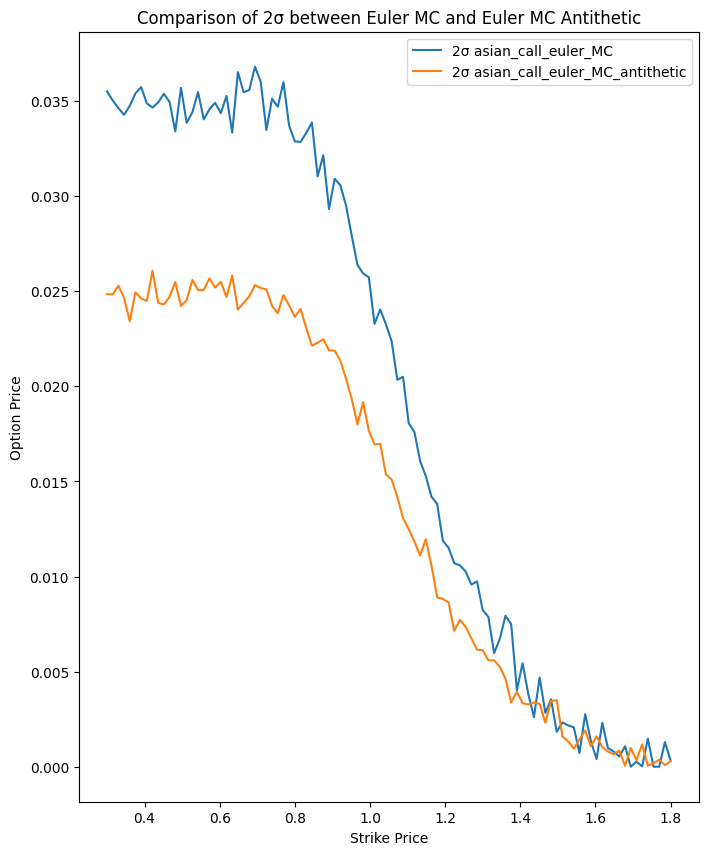

In [ ]:
all_strikes = np.linspace(0.3, 1.8, 100)

fig, ax = plt.subplots(figsize=(8, 10))
val = np.array([asian_call_euler_MC(x_1, x_2, n, 1000, T, strike) for strike in all_strikes])
ax.plot(all_strikes, val[:, 0] - val[:, 1], label='2σ asian_call_euler_MC')

val = np.array([asian_call_euler_MC_antithetic(x_1, x_2, n, 1000, T, strike) for strike in all_strikes])
ax.plot(all_strikes, val[:, 0] - val[:, 1], label='2σ asian_call_euler_MC_antithetic')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Option Price')
ax.set_title('Comparison of 2σ between Euler MC and Euler MC Antithetic')
ax.legend()

plt.show()

Nous remarquons que le réduction de variance fonctionne bien, notamment pour les petites valeurs du Strike.

## Euler-Maruyama + Romberg extrapolation MC - Call asiatique

L'idée principale de l'extrapolation de Romberg est d'utiliser le schéma d'Euler avec différents pas et ensuite d'appliquer l'extrapolation de Richardson pour obtenir une approximation plus précise.

Ici, nous diminuons le pas d'un facteur 2 à chaque fois et nous stockons les différentes valeurs successives dans une matrice R (qui est triangulaire inférieure). Ainsi, sur chaque ligne de R, le pas est diminué d'un facteur 2 et nous calculons les valeurs de la ligne par la formule
$$R_{i,j} = R_{i,j-1} + \frac{R_{i,j-1} - R_{i-1,j-1}}{4^{j-1} - 1}$$

In [ ]:
def asian_call_romberg_euler_MC(x_1, x_2, n, n_paths, T, K, max_level=4):
  """
  Perform Romberg extrapolation with Euler Monte Carlo to price an Asian call option.

  Parameters:
  x_1 (float): Initial value for the first process
  x_2 (float): Initial value for the second process
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time
  K (float): Strike price of the Asian call option
  max_level (int): Maximum level of Romberg extrapolation

  Returns:
  float: Price of the Asian call option
  """
  dt = T / (n - 1)

  # Initialize the Romberg table
  R = np.zeros((max_level + 1, max_level + 1))

  # Compute the Euler-Maruyama scheme for the base case (level 0)
  X_3 = euler_MC(x_1, x_2, n, n_paths, T)
  R[0, 0] = call_payoff(X_3, K).mean()

  # Perform Romberg extrapolation
  for j in range(1, max_level + 1):
      n_new = 2 ** j * (n - 1) + 1
      dt_new = T / (n_new - 1)
      X_3 = euler_MC(x_1, x_2, n_new, n_paths, T)
      R[j, 0] = call_payoff(X_3, K).mean()

      for i in range(1, j + 1):
          R[j, i] = (4 ** i * R[j - 1, i - 1] - R[j - 1, i - 1]) / (4 ** i - 1)

  return R[max_level, max_level]

result = asian_call_romberg_euler_MC(x_1, x_2, n, n_paths, T, K, 4) / T
print('Valeur du Call ', result)

execution_time = timeit.timeit(lambda: asian_call_romberg_euler_MC(x_1, x_2, n, n_paths, T, K, 4), number=5) / 5
print("Average execution time : ", execution_time)
dict_execution_times['asian_call_romberg_euler_MC'] = execution_time

Valeur du Call  0.058954902540237615
Average execution time :  3.764971450800002


## Euler-Maruyama QMC - Call asiatique

Nous avons aussi codé le schéma d'Euler en utilisant une suite à discrépance faible (Quasi Monte Carlo) : nous avons utilisé la suite de Sobol. Il s'agit du même code que précédemment sauf que les variables gaussiennent ne sont plus aléatoires mais en sont obtenues grâce à la suite choisie. Comme cette suite est déterministe, il est très important de générer toutes les variables nécessaires au début de l'exécution afin de s'assurer que nous ne rechoisissons pas deux fois les mêmes termes de la suite.

In [ ]:
def euler_QMC(x_1, x_2, n, n_paths, T) :
  """
  Perform Euler-Maruyama with Quasi Monte Carlo to compute Y_3.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time

  Returns:
  np.array: All values of Y_3 (n_paths values)
  """
  dt = T/(n-1)

  X_1 = np.zeros((n, n_paths))
  X_1[0, :] = x_1
  X_2 = np.zeros((n, n_paths))
  X_2[0, :] = x_2
  X_3 = np.zeros((n, n_paths))
  X_3[0, :] = 0

  dist = qmc.MultivariateNormalQMC(mean=[0, 0], cov=[[dt, 0], [0, dt]], seed=seed, engine=qmc.Sobol(d=2)) # on tire toutes les variables d'un coup
  Z = np.array(dist.random(n_paths*(n-1))).T
  np.random.shuffle(Z[0])
  np.random.shuffle(Z[1])

  for k in range(n-1) :
    X_1[k+1, :] = X_1[k, :] + mu*X_1[k, :]*dt + X_1[k, :]*np.sqrt(X_2[k, :])*Z[0, k*n_paths:(k+1)*n_paths]
    X_2[k+1, :] = X_2[k, :] + alpha*(theta-X_2[k, :])*dt + beta*np.sqrt(X_2[k, :])*Z[1, k*n_paths:(k+1)*n_paths]
    X_3[k+1, :] = X_3[k, :] + X_1[k, :]*dt
  return X_3[-1, :]

def asian_call_euler_QMC(x_1, x_2, n, n_paths, T, K) :
  """
  Compute the price of the call option using Euler-Maruyama with Quasi Monte Carlo.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time
  K(float): Strike

  Returns:
  float: Price of the Asian call option
  """

  result = euler_QMC(x_1, x_2, n, n_paths, T) / T
  return call_payoff(result, K).mean()


value = asian_call_euler_QMC(x_1, x_2, n, n_paths, T, K)
print('Valeur du Call ', value)

execution_time = timeit.timeit(lambda: asian_call_euler_QMC(x_1, x_2, n, n_paths, T, K), number=5) / 5
print("Average execution time : ", execution_time)
dict_execution_times['asian_call_euler_QMC'] = execution_time

/usr/local/lib/python3.10/dist-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Valeur du Call  0.059818207198446285
Average execution time :  0.5808821641999998


## Euler-Maruyama + Romberg extrapolation QMC - Call asiatique

In [ ]:
def asian_call_romberg_euler_QMC(x_1, x_2, n, n_paths, T, K, max_level=4):
  """
  Perform Romberg extrapolation with Euler QMC to price an Asian call option.

  Parameters:
  x_1 (float): Initial value for the first process
  x_2 (float): Initial value for the second process
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time
  K (float): Strike price of the Asian call option
  max_level (int): Maximum level of Romberg extrapolation

  Returns:
  float: Price of the Asian call option
  """
  dt = T / (n - 1)

  # Initialize the Romberg table
  R = np.zeros((max_level + 1, max_level + 1))

  # Compute the Euler-Maruyama scheme for the base case (level 0)
  X_3 = euler_QMC(x_1, x_2, n, n_paths, T)
  R[0, 0] = call_payoff(X_3, K).mean()

  # Perform Romberg extrapolation
  for j in range(1, max_level + 1):
      n_new = 2 ** j * (n - 1) + 1
      dt_new = T / (n_new - 1)
      X_3 = euler_QMC(x_1, x_2, n_new, n_paths, T)
      R[j, 0] = call_payoff(X_3, K).mean()

      for i in range(1, j + 1):
          R[j, i] = (4 ** i * R[j - 1, i - 1] - R[j - 1, i - 1]) / (4 ** i - 1)

  return R[max_level, max_level]

result = asian_call_romberg_euler_QMC(x_1, x_2, n, n_paths, T, K, 4) / T
print('Valeur du Call ', result)

execution_time = timeit.timeit(lambda: asian_call_romberg_euler_QMC(x_1, x_2, n, n_paths, T, K, 4), number=5) / 5
print("Average execution time : ", execution_time)
dict_execution_times['asian_call_romberg_euler_QMC'] = execution_time

Valeur du Call  0.06022121938080304
Average execution time :  12.617045519199996


## Ninomiya MC - Call asiatique

Pour le schéma de Ninomiya & Victoir, nous nous sommes inspiré de leur article. Les variables aléatoires nécessaires sont des lois de Bernoulli et des lois normales.

In [ ]:
def g1(s, Y) :
  J = theta - beta**2 / (4*alpha)
  return Y[0, :] * np.exp((mu - J/2)*s + (Y[1, :]-J)/(2*alpha) * (np.exp(-alpha*s) - 1))

def g2(s, Y) :
  J = theta - beta**2 / (4*alpha)
  return J + (Y[1, :] - J) * np.exp(-alpha*s)

def g3(s, Y) :
  A = mu - Y[1, :]/2
  return Y[2, :] + Y[0, :] * (np.exp(A*s) - 1) / A

def exp_s_V0(s, Y) :
  return np.array([g1(s, Y), g2(s, Y), g3(s, Y)])

def exp_s_V1(s, Y) :
  return np.array([Y[0, :] * np.exp(s * np.sqrt(Y[1, :])), Y[1, :], Y[2, :]])

def exp_s_V2(s, Y) :
  return np.array([Y[0, :], (beta*s/2 + np.sqrt(Y[1, :]))**2, Y[2, :]])

def compute_next(X, k, n, n_paths, Z, gammas) :

  X_gamma_0 = exp_s_V0(1/(2*n), X)
  X_gamma_0 = exp_s_V1(Z[0, k*n_paths:(k+1)*n_paths]/np.sqrt(n), X_gamma_0)
  X_gamma_0 = exp_s_V2(Z[1, k*n_paths:(k+1)*n_paths]/np.sqrt(n), X_gamma_0)
  X_gamma_0 = exp_s_V0(1/(2*n), X_gamma_0)

  X_gamma_1 = exp_s_V0(1/(2*n), X)
  X_gamma_1 = exp_s_V2(Z[1, k*n_paths:(k+1)*n_paths]/np.sqrt(n), X_gamma_1)
  X_gamma_1 = exp_s_V1(Z[0, k*n_paths:(k+1)*n_paths]/np.sqrt(n), X_gamma_1)
  X_gamma_1 = exp_s_V0(1/(2*n), X_gamma_1)

  X = X_gamma_0 + (X_gamma_1 - X_gamma_0) * gammas[:, k*n_paths:(k+1)*n_paths] #si gamma=0, on a X_gamma_0  /  si gamma=1, on a X_gamma_1
  return X

In [ ]:
def ninomiya_MC(x_1, x_2, n, n_paths, T) :
  """
  Perform Ninomiya-Victoir with Monte Carlo to compute Y_3.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time

  Returns:
  np.array: All values of Y_3 (n_paths values)
  """
  X = np.array([[x_1, x_2, 0]] * n_paths).T #X a 3 lignes (Y_1, Y_2 et Y_3) et n_paths colonnes

  # on toutes tire les variables normales
  Z = rng.normal(size=(2, n*n_paths))

  # on tire toutes les variables de Bernoulli
  gammas = rng.binomial(1, 0.5, size=(1, n*n_paths))[0]
  gammas = np.tile(gammas, (3, 1))

  for k in range(n) :
    X = compute_next(X, k, n, n_paths, Z, gammas)
  return X[2, :]

def asian_call_ninomiya_MC(x_1, x_2, n, n_paths, T, K) :
  """
  Compute the price of the call option using Ninomiya-Victoir with Monte Carlo.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time
  K(float): Strike

  Returns:
  tuple: A tuple containing the following values:
    - Price of the Asian call option
    - The lower bound of the 95% confidence interval
    - The upper bound of the 95% confidence interval
  """
  result = ninomiya_MC(x_1, x_2, n, n_paths, T) / T
  alpha = 0.95
  q = norm.ppf((alpha+1)/2) #1.96
  return (call_payoff(result, K).mean(), call_payoff(result, K).mean() - q*np.sqrt(call_payoff(result, K).var()/n), call_payoff(result, K).mean() + q*np.sqrt(call_payoff(result, K).var()/n))

value, IC_inf, IC_sup = asian_call_ninomiya_MC(x_1, x_2, n, n_paths, T, K)
print('Valeur du Call ', value)
print(f'IC- = {IC_inf}')
print(f'IC+ = {IC_sup}')

execution_time = timeit.timeit(lambda: asian_call_ninomiya_MC(x_1, x_2, n, n_paths, T, K), number=5) / 5
print("Average execution time : ", execution_time)
dict_execution_times['asian_call_ninomiya_MC'] = execution_time

Valeur du Call  0.06302338124233009
IC- = 0.04036498734283761
IC+ = 0.08568177514182257
Average execution time :  0.300955468799998


## Nonimiya MC - Réduction de variance - Call asiatique

In [ ]:
def ninomiya_MC_antithetic(x_1, x_2, n, n_paths, T) :
  """
  Perform Ninomiya-Victoir with Monte Carlo and antithetic variance reduction to compute Y_3.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time

  Returns:
  np.array: All values of Y_3 (n_paths values)
  """
  X = np.array([[x_1, x_2, 0]] * n_paths).T #X a 3 lignes (Y_1, Y_2 et Y_3) et n_paths colonnes
  X_prime = np.array([[x_1, x_2, 0]] * n_paths).T

  # on toutes tire les variables normales
  Z = rng.normal(size=(2, n*n_paths))
  Z_prime = (-1)*Z

  # on tire toutes les variables de Bernoulli
  gammas = rng.binomial(1, 0.5, size=(1, n*n_paths))[0]
  gammas = np.tile(gammas, (3, 1))

  for k in range(n) :
    X = compute_next(X, k, n, n_paths, Z, gammas)
    X_prime = compute_next(X_prime, k, n, n_paths, Z_prime, gammas)
  return np.concatenate([X[2, :], X_prime[2, :]], axis=0)

def asian_call_ninomiya_MC_antithetic(x_1, x_2, n, n_paths, T, K) :
  """
  Compute the price of the call option using Ninomiya-Victoir with Monte Carlo and variance reduction.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time
  K(float): Strike

  Returns:
  tuple: A tuple containing the following values:
    - Price of the Asian call option
    - The lower bound of the 95% confidence interval
    - The upper bound of the 95% confidence interval
  """
  result = ninomiya_MC_antithetic(x_1, x_2, n, n_paths, T) / T
  alpha = 0.95
  q = norm.ppf((alpha+1)/2) #1.96
  return (call_payoff(result, K).mean(), call_payoff(result, K).mean() - q*np.sqrt(call_payoff(result, K).var()/(2*n)), call_payoff(result, K).mean() + q*np.sqrt(call_payoff(result, K).var()/(2*n)))

value, IC_inf, IC_sup = asian_call_ninomiya_MC_antithetic(x_1, x_2, n, n_paths, T, K)
print('Valeur du Call ', value)
print(f'IC- = {IC_inf}')
print(f'IC+ = {IC_sup}')

execution_time = timeit.timeit(lambda: asian_call_ninomiya_MC_antithetic(x_1, x_2, n, n_paths, T, K), number=5) / 5
print("Average execution time : ", execution_time)
dict_execution_times['asian_call_ninomiya_MC_antithetic'] = execution_time

Valeur du Call  0.06067395981768974
IC- = 0.04544279446783561
IC+ = 0.07590512516754387
Average execution time :  0.43004957400000876


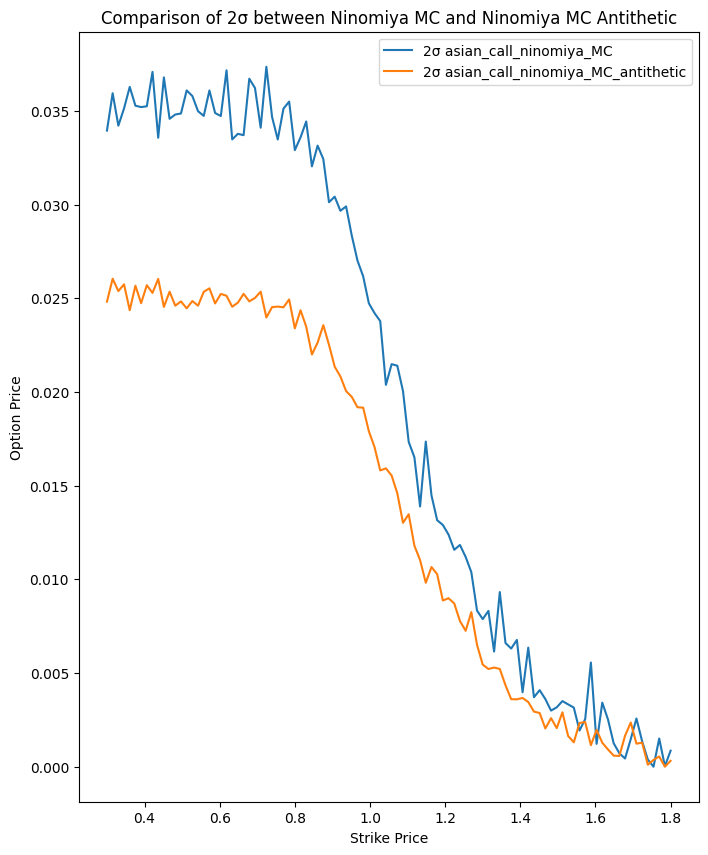

In [ ]:
all_strikes = np.linspace(0.3, 1.8, 100)

fig, ax = plt.subplots(figsize=(8, 10))
val = np.array([asian_call_ninomiya_MC(x_1, x_2, n, 1000, T, strike) for strike in all_strikes])
ax.plot(all_strikes, val[:, 0] - val[:, 1], label='2σ asian_call_ninomiya_MC')

val = np.array([asian_call_ninomiya_MC_antithetic(x_1, x_2, n, 1000, T, strike) for strike in all_strikes])
ax.plot(all_strikes, val[:, 0] - val[:, 1], label='2σ asian_call_ninomiya_MC_antithetic')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Option Price')
ax.set_title('Comparison of 2σ between Ninomiya MC and Ninomiya MC Antithetic')
ax.legend()

plt.show()

Nous remarquons, ici encore, que la méthode des variables antithétiques fonctionne bien, notamment pour les petites valeurs du Strike.

## Ninomiya-Victoir + Romberg extrapolation MC - Call asiatique

In [ ]:
def asian_call_romberg_ninomiya_MC(x_1, x_2, n, n_paths, T, K, max_level=4):
  """
  Perform Romberg extrapolation with Ninomiya Monte Carlo to price an Asian call option.

  Parameters:
  x_1 (float): Initial value for the first process
  x_2 (float): Initial value for the second process
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time
  K (float): Strike price of the Asian call option
  max_level (int): Maximum level of Romberg extrapolation

  Returns:
  float: Price of the Asian call option
  """
  dt = T / (n - 1)

  # Initialize the Romberg table
  R = np.zeros((max_level + 1, max_level + 1))

  # Compute the Euler-Maruyama scheme for the base case (level 0)
  X_3 = ninomiya_MC(x_1, x_2, n, n_paths, T)
  R[0, 0] = call_payoff(X_3, K).mean()

  # Perform Romberg extrapolation
  for j in range(1, max_level + 1):
      n_new = 2 ** j * (n - 1) + 1
      dt_new = T / (n_new - 1)
      X_3 = ninomiya_MC(x_1, x_2, n, n_paths, T)
      R[j, 0] = call_payoff(X_3, K).mean()

      for i in range(1, j + 1):
          R[j, i] = (4 ** i * R[j - 1, i - 1] - R[j - 1, i - 1]) / (4 ** i - 1)

  return R[max_level, max_level]

result = asian_call_romberg_ninomiya_MC(x_1, x_2, n, n_paths, T, K, 4) / T
print('Valeur du Call ', result)

execution_time = timeit.timeit(lambda: asian_call_romberg_ninomiya_MC(x_1, x_2, n, n_paths, T, K, 4), number=5) / 5
print("Average execution time : ", execution_time)
dict_execution_times['asian_call_romberg_ninomiya_MC'] = execution_time

Valeur du Call  0.05981947596609131
Average execution time :  1.402852390199996


## Ninomiya QMC - Call asiatique

Ce schéma fonctionne aussi en Quasi Monte Carlo. Pour cela, il suffit d'utiliser une suite à discrépance faible pour générer des variables de Bernoulli et des variables gaussiennes.

In [ ]:
def ninomiya_QMC(x_1, x_2, n, n_paths, T) :
  """
  Perform Ninomiya-Victoir with Quasi Monte Carlo to compute Y_3.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time

  Returns:
  np.array: All values of Y_3 (n_paths values)
  """
  X = np.array([[x_1, x_2, 0]] * n_paths).T #X a 3 lignes (Y_1, Y_2 et Y_3) et n_paths colonnes

  # on tire les variables normales
  dist = qmc.MultivariateNormalQMC(mean=[0, 0], cov=[[1, 0], [0, 1]], seed=seed, engine=qmc.Sobol(d=2))
  Z = np.array(dist.random(n*n_paths)).T
  np.random.shuffle(Z[0])
  np.random.shuffle(Z[1])

  # on tire toutes les variables de Bernoulli
  sampler = qmc.Sobol(d=1, scramble=True, seed=seed)
  gammas = np.round(sampler.random(n=n*n_paths)).T # permet de transformer la suite de Sobol sur [0,1] en variable de Bernoulli
  gammas = np.tile(gammas, (3, 1))

  for k in range(n) :
    X = compute_next(X, k, n, n_paths, Z, gammas)
  return X[2, :]

def asian_call_ninomiya_QMC(x_1, x_2, n, n_paths, T, K) :
  """
  Compute the price of the call option using Ninomiya-Victoir with Quasi Monte Carlo.

  Parameters:
  x_1 (float): Initial value for the first process Y_1
  x_2 (float): Initial value for the second process Y_2
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time
  K(float): Strike

  Returns:
  float: Price of the Asian call option
  """
  result = ninomiya_QMC(x_1, x_2, n, n_paths, T) / T
  return call_payoff(result, K).mean()

value = asian_call_ninomiya_QMC(x_1, x_2, n, n_paths, T, K)
print('Valeur du Call ', value)

execution_time = timeit.timeit(lambda: asian_call_ninomiya_QMC(x_1, x_2, n, n_paths, T, K), number=5) / 5
print("Average execution time : ", execution_time)
dict_execution_times['asian_call_ninomiya_QMC'] = execution_time

Valeur du Call  0.061168554056545824
Average execution time :  0.49287489340001683


## Ninomiya-Victoir + Romberg extrapolation QMC - Call asiatique

In [ ]:
def asian_call_romberg_ninomiya_QMC(x_1, x_2, n, n_paths, T, K, max_level=4):
  """
  Perform Romberg extrapolation with Ninomiya Quasi Monte Carlo to price an Asian call option.

  Parameters:
  x_1 (float): Initial value for the first process
  x_2 (float): Initial value for the second process
  n (int): Number of time steps
  n_paths (int): Number of Monte Carlo paths
  T (float): Final time
  K (float): Strike price of the Asian call option
  max_level (int): Maximum level of Romberg extrapolation

  Returns:
  float: Price of the Asian call option
  """
  dt = T / (n - 1)

  # Initialize the Romberg table
  R = np.zeros((max_level + 1, max_level + 1))

  # Compute the Euler-Maruyama scheme for the base case (level 0)
  X_3 = ninomiya_QMC(x_1, x_2, n, n_paths, T)
  R[0, 0] = call_payoff(X_3, K).mean()

  # Perform Romberg extrapolation
  for j in range(1, max_level + 1):
      n_new = 2 ** j * (n - 1) + 1
      dt_new = T / (n_new - 1)
      X_3 = ninomiya_QMC(x_1, x_2, n, n_paths, T)
      R[j, 0] = call_payoff(X_3, K).mean()

      for i in range(1, j + 1):
          R[j, i] = (4 ** i * R[j - 1, i - 1] - R[j - 1, i - 1]) / (4 ** i - 1)

  return R[max_level, max_level]

result = asian_call_romberg_ninomiya_QMC(x_1, x_2, n, n_paths, T, K, 4) / T
print('Valeur du Call ', result)

execution_time = timeit.timeit(lambda: asian_call_romberg_ninomiya_QMC(x_1, x_2, n, n_paths, T, K, 4), number=5) / 5
print("Average execution time : ", execution_time)
dict_execution_times['asian_call_romberg_ninomiya_QMC'] = execution_time

Valeur du Call  0.0592777908774538
Average execution time :  3.008061279000003


## Comparaison des temps d'exécution à `n_paths` constant

Une première manière de comparer les différents modèles de dicrétisation est de comparer les temps d'exécution. Pour cela, nous avons décidé de les comparer en maintenant `n_paths` constant. Afin que cette comparaison ait un sens, nous avons séparé les méthodes Monte Carlo et Quasi Monte Carlo puisque les méthodes QMC ont justement pour but de converger en ayant besoin de moins de points (si on force le même nombre de points, elles sont plus lentes mais founissent une valeur théoriquement plus précise).

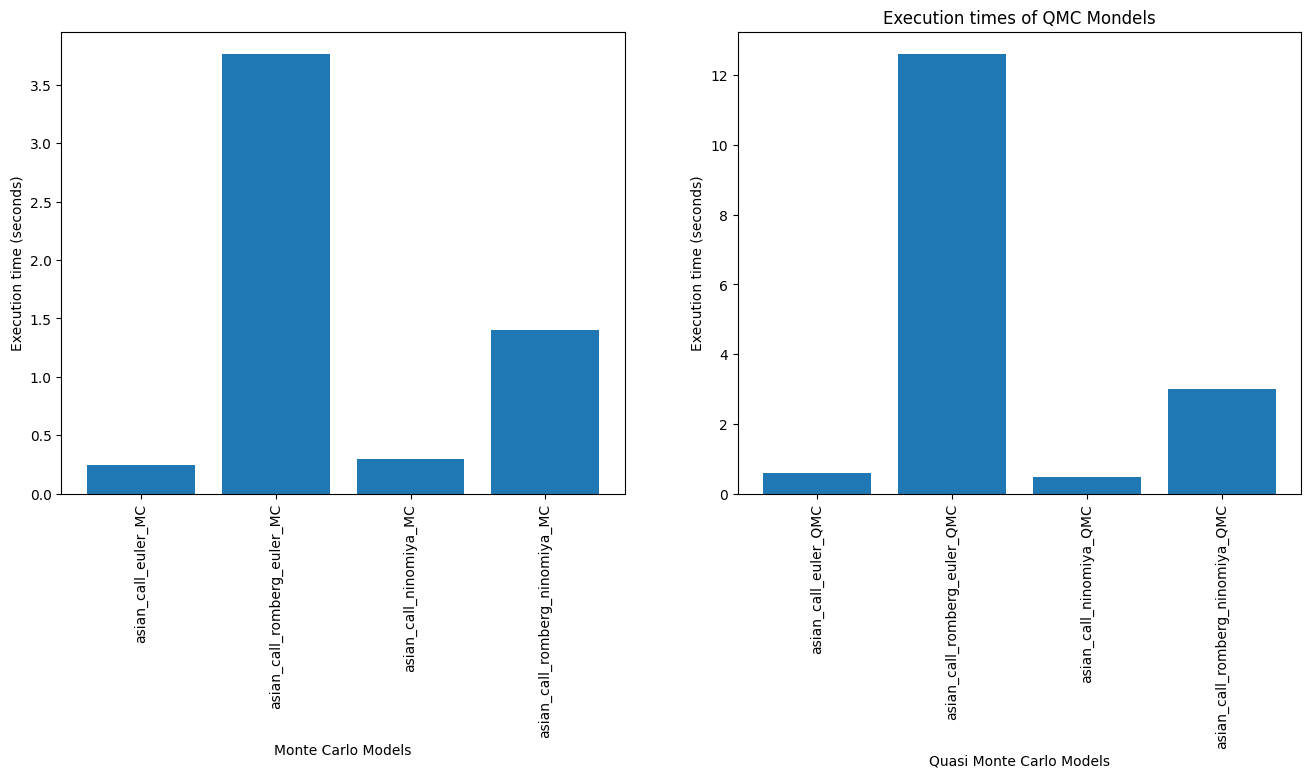

In [ ]:
model_names_MC = ['asian_call_euler_MC', 'asian_call_romberg_euler_MC', 'asian_call_ninomiya_MC', 'asian_call_romberg_ninomiya_MC']
execution_times_MC = [dict_execution_times[model] for model in model_names_MC]

model_names_QMC = ['asian_call_euler_QMC','asian_call_romberg_euler_QMC', 'asian_call_ninomiya_QMC', 'asian_call_romberg_ninomiya_QMC']
execution_times_QMC = [dict_execution_times[model] for model in model_names_QMC]

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].bar(model_names_MC, execution_times_MC)
ax[0].set_xlabel('Monte Carlo Models')
ax[0].set_ylabel('Execution time (seconds)')
ax[0].set_xticks(range(len(model_names_MC)))
ax[0].set_xticklabels(model_names_MC, rotation=90)

ax[1].bar(model_names_QMC, execution_times_QMC)
ax[1].set_xlabel('Quasi Monte Carlo Models')
ax[1].set_ylabel('Execution time (seconds)')
ax[1].set_title('Execution times of QMC Mondels')
ax[1].set_xticks(range(len(model_names_QMC)))
ax[1].set_xticklabels(model_names_QMC, rotation=90)

plt.show()

Nous pouvons faire plusieurs remarques :


*   Tout d'abord, les méthodes QMC sont effectivement plus longues à s'exécuter pour un même nombre de points (sans surprise, puisqu'elles ont justement pour but d'être exécutées avec moins de points qu'une méthode MC)
*   Les deux diagrammes se ressemblent en terme de proportions. En effet, le schéma d'Euler classique est le plus rapide, tandis que le schéma d'Euler avec une extrapolation de Romberg est le plus long.
*   Nous remarquons aussi que le schéma de Ninomiya & Victoir se comporte très bien (il a un faible temps d'exécution y compris avec une extrapolation de Romberg).



## Comparaison des schémas pour différents strikes

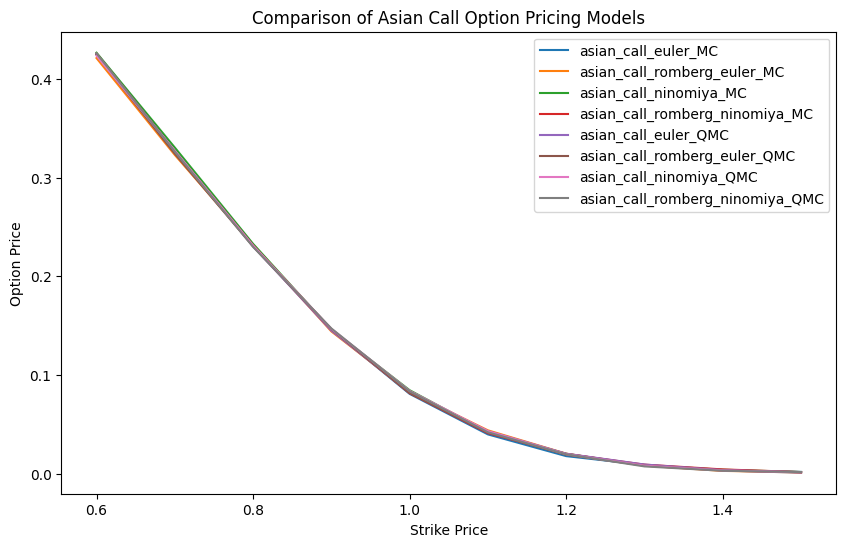

In [ ]:
all_strikes = np.linspace(0.6, 1.5, 10)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(all_strikes, [asian_call_euler_MC(x_1, x_2, n, n_paths, T, strike)[0] for strike in all_strikes], label='asian_call_euler_MC')
ax.plot(all_strikes, [asian_call_romberg_euler_MC(x_1, x_2, n, n_paths, T, strike) for strike in all_strikes], label='asian_call_romberg_euler_MC')
ax.plot(all_strikes, [asian_call_ninomiya_MC(x_1, x_2, n, n_paths, T, strike)[0] for strike in all_strikes], label='asian_call_ninomiya_MC')
ax.plot(all_strikes, [asian_call_romberg_ninomiya_MC(x_1, x_2, n, n_paths, T, strike) for strike in all_strikes], label='asian_call_romberg_ninomiya_MC')
ax.plot(all_strikes, [asian_call_euler_QMC(x_1, x_2, n, n_paths, T, strike) for strike in all_strikes], label='asian_call_euler_QMC')
ax.plot(all_strikes, [asian_call_romberg_euler_QMC(x_1, x_2, n, n_paths, T, strike) for strike in all_strikes], label='asian_call_romberg_euler_QMC')
ax.plot(all_strikes, [asian_call_ninomiya_QMC(x_1, x_2, n, n_paths, T, strike) for strike in all_strikes], label='asian_call_ninomiya_QMC')
ax.plot(all_strikes, [asian_call_romberg_ninomiya_QMC(x_1, x_2, n, n_paths, T, strike) for strike in all_strikes], label='asian_call_romberg_ninomiya_QMC')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Option Price')
ax.set_title('Comparison of Asian Call Option Pricing Models')
ax.legend()

plt.show()

Les différentes valeurs de notre option sont les mêmes pour tous les schémas, même si nous faisons varier le strike.

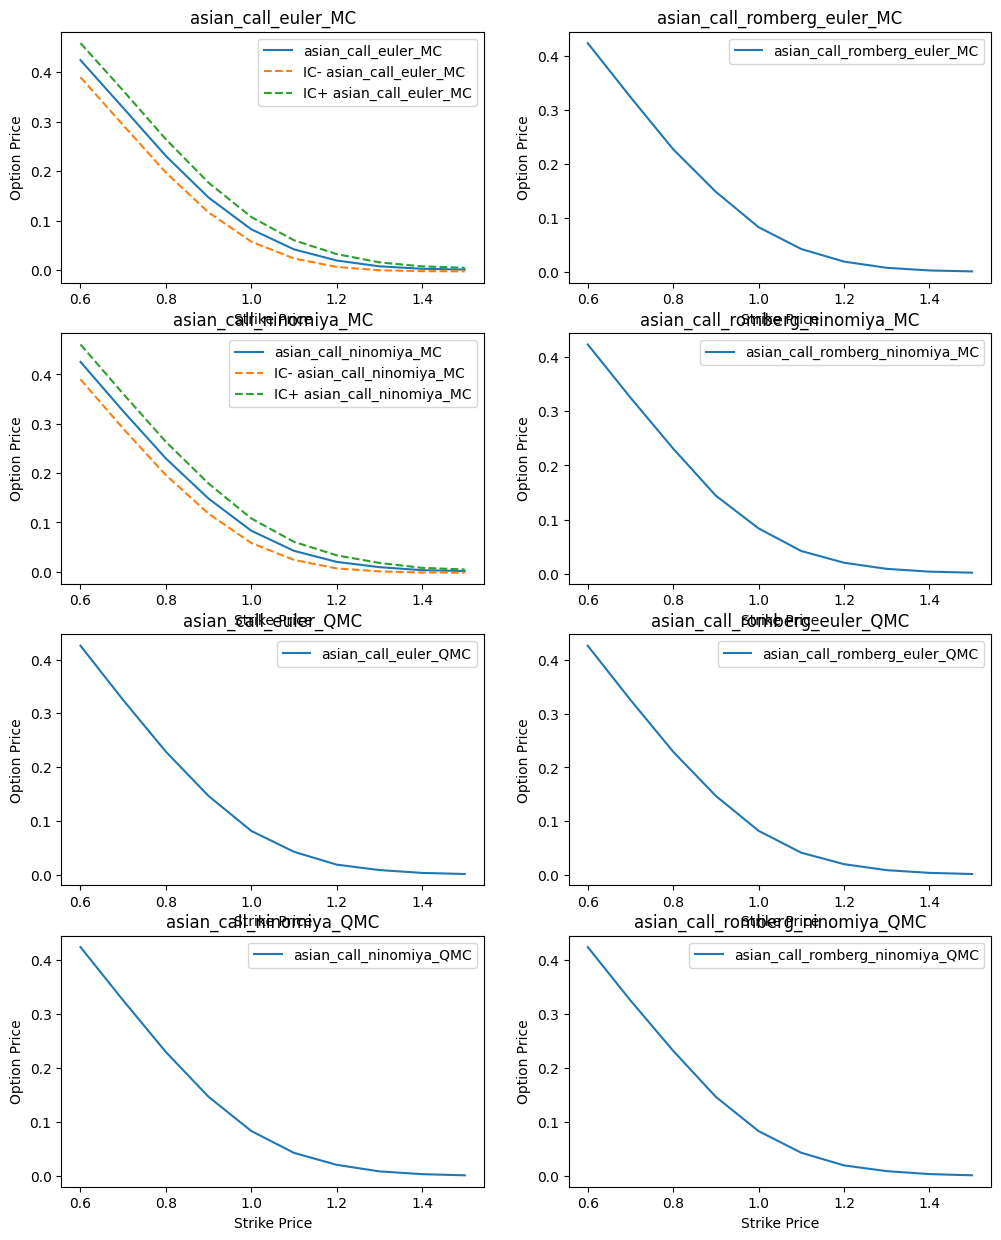

In [ ]:
model_names = [
    'asian_call_euler_MC',
    'asian_call_romberg_euler_MC',
    'asian_call_ninomiya_MC',
    'asian_call_romberg_ninomiya_MC',
    'asian_call_euler_QMC',
    'asian_call_romberg_euler_QMC',
    'asian_call_ninomiya_QMC',
    'asian_call_romberg_ninomiya_QMC'
]

fig, axs = plt.subplots(4, 2, figsize=(12, 15))

for i, model_name in enumerate(model_names):
    model_func = globals()[model_name]
    row = i // 2
    col = i % 2
    if model_name in ['asian_call_euler_MC', 'asian_call_ninomiya_MC']:
      val = np.array([model_func(x_1, x_2, n, n_paths, T, strike) for strike in all_strikes])
      axs[row, col].plot(all_strikes, val[:, 0], label=model_name)
      axs[row, col].plot(all_strikes, val[:, 1], '--', label=f'IC- {model_name}')
      axs[row, col].plot(all_strikes, val[:, 2], '--', label=f'IC+ {model_name}')
    else:
      axs[row, col].plot(all_strikes, [model_func(x_1, x_2, n, n_paths, T, strike) for strike in all_strikes], label=model_name)
    axs[row, col].set_xlabel('Strike Price')
    axs[row, col].set_ylabel('Option Price')
    axs[row, col].set_title(model_name)
    axs[row, col].legend()

plt.show()

## Erreur de convergence

Pour comparer nous différents schémas, nous pouvons aussi observer leur erreur de convergence. Pour cela, l'article de Ninomiya & Victoir propose de fixer cette erreur à $2\sigma$ lorsque l'écart-type à un sens (c'est-à-dire lorsque nous utilisons une simulation de Monte Carlo). Lorsque nous utilisons une méthode QMC, nous n'avons pas d'intervalle de confiance et l'article propose alors de regarder la valeur absolue de la différence le prix du schéma et un prix de $6.0473907415 * 10^{-2}$. Cela est très largement criticable puisque cette valeur a, elle aussi, été obtenue par simulation QMC.

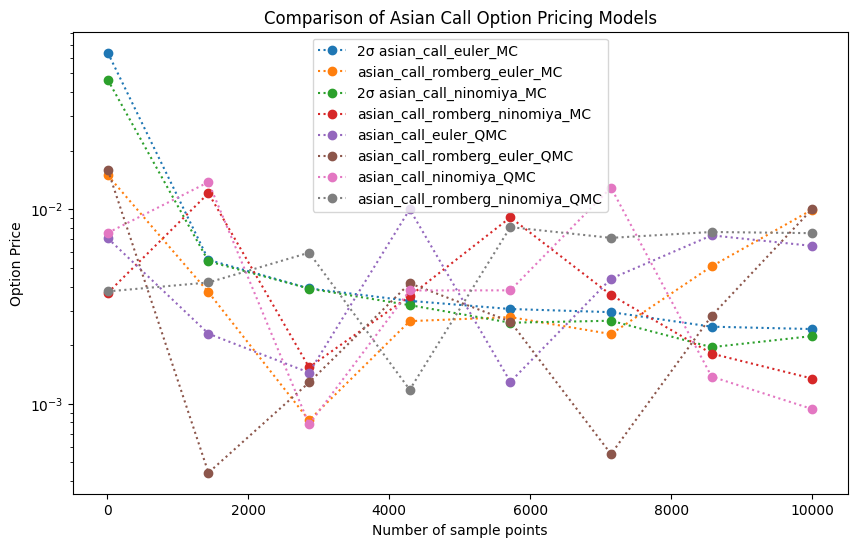

In [ ]:
ref_value = 6.0473907415e-2   # Valeur de référence dans le papier de Ninomiya & Victoir
all_n = np.linspace(1e1, 1e4, 8).astype(int)

fig, ax = plt.subplots(figsize=(10, 6))

val = np.array([asian_call_euler_MC(x_1, x_2, num_points, 200, T, K) for num_points in all_n])
ax.plot(all_n,  val[:, 0] - val[:, 1], ":o", label='2σ asian_call_euler_MC')
ax.plot(all_n, [np.abs(asian_call_romberg_euler_MC(x_1, x_2, num_points, 200, T, K) - ref_value) for num_points in all_n], ":o", label='asian_call_romberg_euler_MC')
val = np.array([asian_call_ninomiya_MC(x_1, x_2, num_points, 200, T, K) for num_points in all_n])
ax.plot(all_n, val[:, 0] - val[:, 1], ":o", label='2σ asian_call_ninomiya_MC')
ax.plot(all_n, [np.abs(asian_call_romberg_ninomiya_MC(x_1, x_2, num_points, 200, T, K) - ref_value) for num_points in all_n], ":o", label='asian_call_romberg_ninomiya_MC')
ax.plot(all_n, [np.abs(asian_call_euler_QMC(x_1, x_2, num_points, 200, T, K) - ref_value) for num_points in all_n], ":o", label='asian_call_euler_QMC')
ax.plot(all_n, [np.abs(asian_call_romberg_euler_QMC(x_1, x_2, num_points, 200, T, K) - ref_value) for num_points in all_n], ":o", label='asian_call_romberg_euler_QMC')
ax.plot(all_n, [np.abs(asian_call_ninomiya_QMC(x_1, x_2, num_points, 200, T, K) - ref_value) for num_points in all_n], ":o", label='asian_call_ninomiya_QMC')
ax.plot(all_n, [np.abs(asian_call_romberg_ninomiya_QMC(x_1, x_2, num_points, 200, T, K) - ref_value) for num_points in all_n], ":o", label='asian_call_romberg_ninomiya_QMC')

ax.set_xlabel('Number of sample points')
ax.set_ylabel('Option Price')
ax.set_title('Comparison of Asian Call Option Pricing Models')
ax.set_yscale('log')
ax.legend()

plt.show()

Nous remarquons que :

*   Pour tous les schémas, l'erreur décroît lorsque nous diminuons le pas de discrétisation (augmentation du nombre de points).
*   Il semble que le schéma Ninomiya et Victoir avec Romberg extrapolation MC, mais aussi Ninomiya et Victoir avec Romberg extrapolation QMC ont effectivement de meilleurs résultats. Bien que cette différence ne soit pas aussi évidente que dans le papier de Ninomiya & Victoir, elle se voit tout de même légèrement.

## Comparaison de la variance entre Euler et Ninomiya

Lorsque nous réalisons une simulation de Monte Carlo, il est souhaitable d'avoir le plus petit intervalle de confiance possible. Comparons alors $2\sigma$ pour le schéma d'Euler et le schéma de Ninomiya.

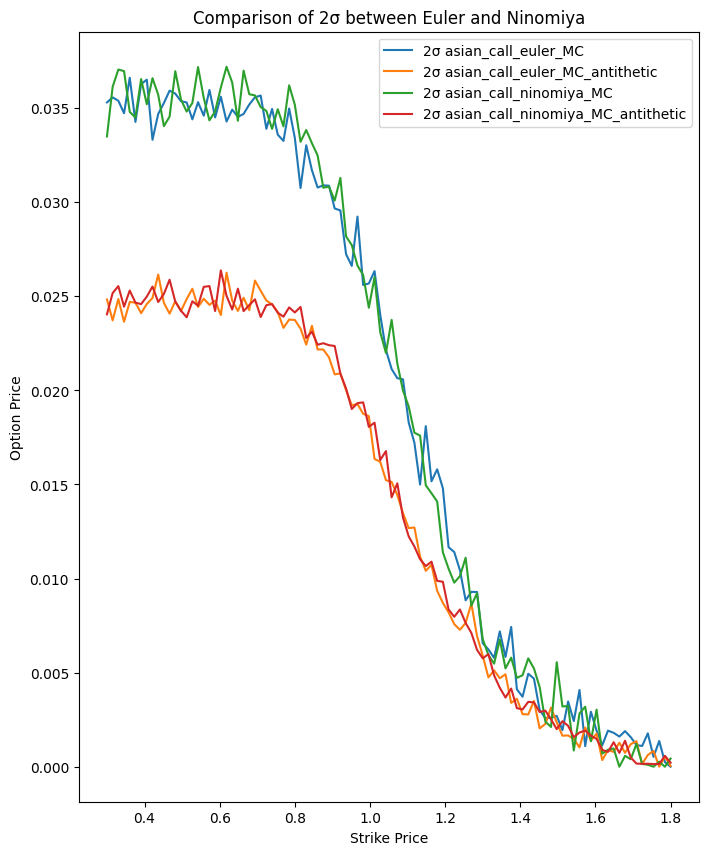

In [ ]:
all_strikes = np.linspace(0.3, 1.8, 100)

fig, ax = plt.subplots(figsize=(8, 10))
val = np.array([asian_call_euler_MC(x_1, x_2, n, 1000, T, strike) for strike in all_strikes])
ax.plot(all_strikes, val[:, 0] - val[:, 1], label='2σ asian_call_euler_MC')

val = np.array([asian_call_euler_MC_antithetic(x_1, x_2, n, 1000, T, strike) for strike in all_strikes])
ax.plot(all_strikes, val[:, 0] - val[:, 1], label='2σ asian_call_euler_MC_antithetic')

val = np.array([asian_call_ninomiya_MC(x_1, x_2, n, 1000, T, strike) for strike in all_strikes])
ax.plot(all_strikes, val[:, 0] - val[:, 1], label='2σ asian_call_ninomiya_MC')

val = np.array([asian_call_ninomiya_MC_antithetic(x_1, x_2, n, 1000, T, strike) for strike in all_strikes])
ax.plot(all_strikes, val[:, 0] - val[:, 1], label='2σ asian_call_ninomiya_MC_antithetic')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Option Price')
ax.set_title('Comparison of 2σ between Euler and Ninomiya')
ax.legend()

plt.show()

On remarque que les deux schémas ont une variance du même ordre de grandeur.

# **2 - Heston model CIR**

Reproduisons les schémas présentés dans le papier de A. Alfonsi.

In [ ]:
# Set parameters
X_01, X_03 = 0.04, 100
k = 0.5
a = 0.02
sigma1, sigma2 = 0.4, 1
r = 0.02
rho1, rho2 = -0.5, -0.8
T = 1
S1, S2, S3 = 80, 100, 120

# Function to price European put option
def european_put_option(S, K, r, T):
    return np.exp(-r * T) * np.mean(np.maximum(K - S, 0))

# Function to price Asian put option
def asian_put_option(S, K, r, T):
    # Calculate the average stock price
    avg_S = np.mean(S, axis=0)
    return np.exp(-r * T) * np.mean(np.maximum(K - avg_S, 0))

# Function to price exotic option
def exotic_option(S, K1, K2, r, T):
    payoff = np.maximum(0, np.maximum(S - K1, 0) - np.maximum(S - K2, 0))
    return np.exp(-r * T) * np.mean(payoff)

def calculate_confidence_interval(data, confidence_level):
    mean = np.mean(data)
    std_dev = np.std(data)
    n_samples = len(data)
    moe = stats.t.ppf((1 + confidence_level) / 2, n_samples - 1) * std_dev / np.sqrt(n_samples)
    lower_bound = mean - moe
    upper_bound = mean + moe
    return lower_bound, upper_bound

def plot_with_confidence_intervals(df, xlabel='Value of n', ylabel='Value of the put', title='European Put', confidence_level=0.95, label=None):
    """
    Plot the means of the DataFrame along with their 95% confidence intervals.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        r (float): Interest rate.
        xlabel (str): Label for the x-axis. Default is 'Value of n'.
        ylabel (str): Label for the y-axis. Default is 'Value of the put'.
        title (str): Title for the plot. Default is 'European Put'.
        confidence_level (float): Confidence level for the intervals. Default is 0.95.
        label (str or None): Label for the plot. Default is None.
    """
    # Calculate means and standard deviations
    means = df.mean(axis=1).values
    std_devs = df.std(axis=1).values

    # Calculate standard errors of the mean (SEM)
    sem = std_devs / np.sqrt(df.shape[1])

    # Calculate margin of errors (MOE)
    moe = sem * stats.t.ppf((1 + confidence_level) / 2, df.shape[1] - 1)

    # Calculate confidence intervals
    lower_bound = means - moe
    upper_bound = means + moe

    # Plotting
    plt.figure(figsize=(20, 5))

    # Plot line
    plt.plot(df.index, means, label=label)

    # Plot confidence interval
    plt.fill_between(df.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')

    # Labeling
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    # Show plot
    plt.show()

def calculate_confidence_interval(data, confidence_level):
    mean = np.mean(data)
    std_dev = np.std(data)
    n_samples = len(data)
    moe = stats.t.ppf((1 + confidence_level) / 2, n_samples - 1) * std_dev / np.sqrt(n_samples)
    lower_bound = mean - moe
    upper_bound = mean + moe
    return lower_bound, upper_bound

def plot_with_confidence_intervals_subplot(ax, df, xlabel='Value of n', ylabel='Value of the put', title='European Put', confidence_level=0.95, label=None):
    """
    Plot the means of the DataFrame along with their 95% confidence intervals on a subplot.

    Parameters:
        ax (matplotlib.axes.Axes): The subplot axes.
        df (pandas.DataFrame): The DataFrame containing the data.
        xlabel (str): Label for the x-axis. Default is 'Value of n'.
        ylabel (str): Label for the y-axis. Default is 'Value of the put'.
        title (str): Title for the plot. Default is 'European Put'.
        confidence_level (float): Confidence level for the intervals. Default is 0.95.
        label (str or None): Label for the plot. Default is None.
    """
    # Calculate means and standard deviations
    means = df.mean(axis=1).values
    std_devs = df.std(axis=1).values

    # Calculate standard errors of the mean (SEM)
    sem = std_devs / np.sqrt(df.shape[1])

    # Calculate margin of errors (MOE)
    moe = sem * stats.t.ppf((1 + confidence_level) / 2, df.shape[1] - 1)

    # Calculate confidence intervals
    lower_bound = means - moe
    upper_bound = means + moe

    # Plot line
    ax.plot(df.index, means, label=label)

    # Plot confidence interval
    ax.fill_between(df.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')

    # Labeling
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

# Scheme 1: Second Order Scheme

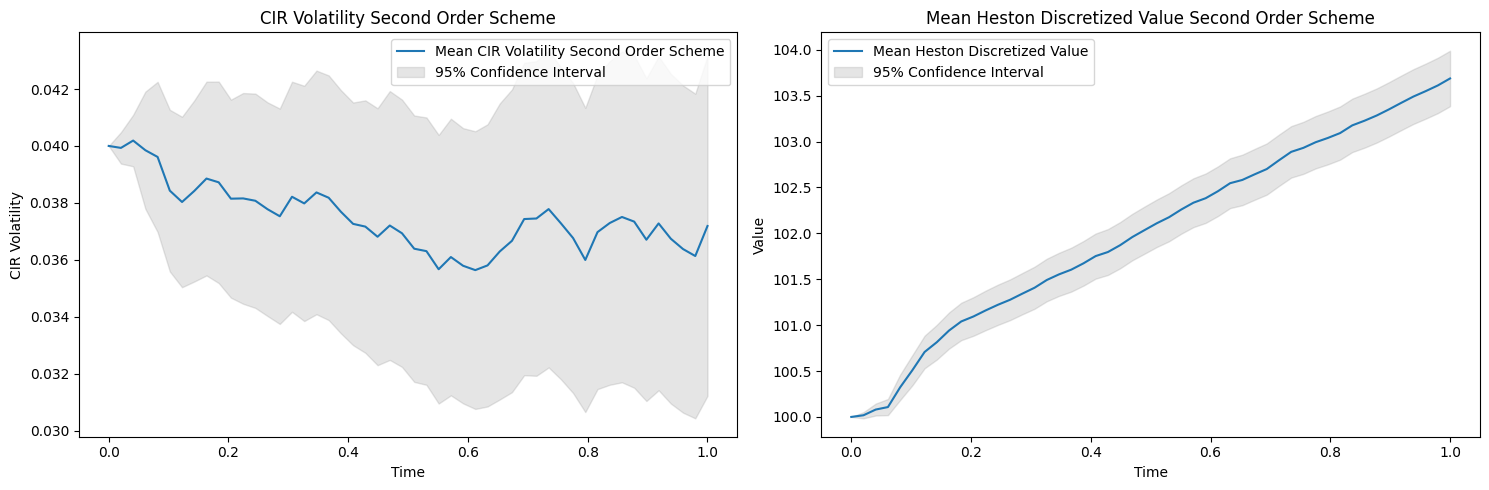

In [ ]:
# Function to generate samples of Y
def generate_samples(n): return np.random.choice([np.sqrt(3), 0, -np.sqrt(3)], size=n , p=[1/6, 2/3, 1/6])

def psi_k(k,t): return t if k==0 else (1 - np.exp(-k*t)) / k

def phi(x, t, w, a, k, sigma): return np.exp(-k * t / 2) * (np.sqrt((a - sigma**2 / 4) * psi_k(k, t / 2) + np.exp(-k * t / 2) * x) + w * sigma / 2)**2 + (a - sigma**2 / 4) * psi_k(k, t / 2)

def K2(t, sigma, a, k): return np.exp(k * t / 2) * (((sigma**2 / 4) - a) * psi_k(k, t/2) + (np.sqrt(np.exp(k * t / 2) * ((sigma**2 / 4 - a) * psi_k(k, t/2))) + np.sqrt(3 * t) * sigma / 2 )**2) if sigma**2 > 4 * a else 0

def u_tilde_1(t, x, a, k): return x * np.exp(-k * t) + a * psi_k(k, t)

def u_tilde_2(t, x, a, k, sigma): return u_tilde_1(t, x, a, k)**2 + sigma**2 * psi_k(t, k) * (a * psi_k(t, k) / 2 + x * np.exp(-k * t))

def discriminant(t, x, a, k, sigma):
    delta = 1 - (u_tilde_1(t, x, a, k)**2) / u_tilde_2(t, x, a, k, sigma)
    return np.where(delta >= 0, delta, 0)

def pi_function(t, x, a, k, sigma): return (1 - np.sqrt(discriminant(t, x, a, k, sigma))) / 2

def generator_p_hat_x(t, x, K2_t, a, k, sigma, Normal):
    new_x, mask_1 = np.zeros_like(x), x < K2_t
    if np.any(mask_1):
        pi_val = pi_function(t, x[mask_1], a, k, sigma)
        density_1, density_2, U = u_tilde_1(t, x[mask_1], a, k) / (2 * pi_val), u_tilde_1(t, x[mask_1], a, k) / (2 * (1 - pi_val)), np.random.uniform(0, 1, size=np.sum(mask_1))
        new_x[mask_1] = density_1 * (U <= pi_val) + density_2 * (U > pi_val)
    if np.any(~mask_1):
        Y = generate_samples(x[~mask_1].shape) if not Normal else np.random.normal(loc=0,scale=1,size=x[~mask_1].shape)
        new_x[~mask_1] = phi(x[~mask_1], t, np.sqrt(t) * Y, a, k, sigma)
    return new_x

def XCIR_2ndOrder(x_1, a, k, sigma, T, n, n_paths, K_factor=1, Normal=False):
    paths, K2_t, dt = np.zeros((n_paths, n)), np.zeros((n_paths, n)), T / n
    paths[:, 0] = x_1
    for i in range(1, n): paths[:, i] = generator_p_hat_x(dt, paths[:, i-1], K_factor * K2(dt, sigma, a, k), a, k, sigma, Normal)
    return paths.T

# Function to simulate the Heston model
def heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, n, n_paths, XCIR):
    temp, X_1, X_2, X_3, X_4 = np.zeros((n, n_paths)), np.zeros((n, n_paths)), np.zeros((n, n_paths)), np.zeros((n, n_paths)), np.zeros((n, n_paths))
    X_1[0, :], X_2[0, :], X_3[0, :], X_4[0, :] = X_01, 0, X_03, 0
    dt = T/n
    Z = rng.normal(loc=0, scale=1, size=(n, n_paths))
    # U = np.random.randint(2,size=(n, n_paths))
    # Z = generate_samples((n, n_paths))
    temp = XCIR(X_01, a, k, sigma, T, n, n_paths)

    for j in range(n-1):
      X_1[j+1, :] = temp[j, :]
      X_2[j+1, :] = X_2[j, :] + 0.5 * (X_1[j, :] + temp[j, :]) * dt
      X_3[j+1, :] = (X_3[j, :] * np.exp((r - rho * a / sigma) * dt + 0.5 * dt * (X_1[j, :] + temp[j, :]) * (k * rho / sigma - 0.5) + (rho / sigma) * (temp[j, :] - X_1[j, :])))*np.exp(np.sqrt(dt * X_1[j, :] * (1 - rho**2)) * Z[j, :])
      # mask = (U[j,:] == 1)
      # X_3[j+1, :][mask] = (X_3[j, :][mask] * np.exp((r - rho * a / sigma) * dt + 0.5 * dt * (X_1[j, :][mask] + temp[j, :][mask]) * (k * rho / sigma - 0.5) + (rho / sigma) * (temp[j, :][mask] - X_1[j, :][mask])))
      # X_3[j+1, :][~mask] = X_3[j, :][~mask]*np.exp(np.sqrt(dt * X_1[j, :][~mask] * (1 - rho**2)) * Z[j, :][~mask])
      X_4[j+1, :] = X_4[j, :] + 0.5 * dt * X_3[j, :] * (1 + np.exp((r - rho * a / sigma) * dt + 0.5 * dt * (X_1[j, :] + temp[j, :]) * (k * rho / sigma - 0.5)  + (rho / sigma) * (temp[j, :] - X_1[j, :])))

    return X_3

n = int(50) #nombre de points
n_paths = int(1e4)

# Example usage:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the first graph
paths = XCIR_2ndOrder(X_01, a, k, sigma2, T, n, n_paths)
df_paths = pd.DataFrame(paths)
df_paths.index = np.linspace(0, 1, len(df_paths))
plot_with_confidence_intervals_subplot(axs[0], df_paths, xlabel='Time', ylabel='CIR Volatility', title='CIR Volatility Second Order Scheme', label='Mean CIR Volatility Second Order Scheme')

# Plot the second graph
df_test = pd.DataFrame(heston_scheme_discretized(X_01, X_03, k, a, sigma2, r, rho2, T, n, n_paths, XCIR_2ndOrder))
df_test.index = np.linspace(0, 1, len(df_test))
plot_with_confidence_intervals_subplot(axs[1], df_test, xlabel='Time', ylabel='Value', title='Mean Heston Discretized Value Second Order Scheme', label='Mean Heston Discretized Value')

plt.tight_layout()
plt.show()

In [ ]:
n = int(50) #nombre de points
n_paths = int(1e6)

# Define sigma and rho values
strike_prices = [S1, S2, S3]
sigma_values = [sigma1, sigma2]
rho_values = [rho1, rho2]

# Define the exotic option strike prices
exotic_K1, exotic_K2 = 80, 120

# Initialize lists to store data
sigma_list, rho_list, strike_price_list, asian_put_price_list, european_put_price_list, exotic_put_price_list = [], [], [], [], [], []
simulation_results, asian_put_prices, european_put_prices, exotic_put_prices = {}, {}, {}, {}

# Calculate option prices and simulation results for each sigma, rho, and strike price
for sigma, rho in zip(sigma_values,rho_values):
    # Simulate Heston model for the current sigma and rho values
    result_sigma_rho = heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, n, n_paths, XCIR_2ndOrder)
    # Store the simulation result for the current sigma and rho values
    simulation_results[(sigma, rho)] = result_sigma_rho

    # Initialize dictionaries for the current sigma and rho values
    asian_put_prices[(sigma, rho)] = {}
    european_put_prices[(sigma, rho)] = {}
    exotic_put_prices[(sigma, rho)] = {}

    # Calculate option prices for each strike price
    for K in strike_prices:
        # Asian put option prices
        asian_put_price = asian_put_option(result_sigma_rho, K, r, T)
        asian_put_prices[(sigma, rho)][K] = asian_put_option(result_sigma_rho, K, r, T)

        # European put option prices
        european_put_price = european_put_option(result_sigma_rho[-1, :], K, r, T)
        exotic_put_price = exotic_option(result_sigma_rho[-1, :], exotic_K1, exotic_K2, r, T)

        # European put option prices
        european_put_prices[(sigma, rho)][K] = european_put_option(result_sigma_rho[-1, :], K, r, T)
        exotic_put_prices[(sigma, rho)][K] = exotic_option(result_sigma_rho[-1, :], exotic_K1, exotic_K2, r, T)

        # Append data to lists
        sigma_list.append(sigma)
        rho_list.append(rho)
        strike_price_list.append(K)
        asian_put_price_list.append(asian_put_price)
        european_put_price_list.append(european_put_price)
        exotic_put_price_list.append(exotic_put_price)

# Construct the DataFrame
df = pd.DataFrame({
    'Sigma': sigma_list,
    'Rho': rho_list,
    'Strike Price': strike_price_list,
    'Asian Put Price': asian_put_price_list,
    'European Put Price': european_put_price_list,
    'Exotic Put Price': exotic_put_price_list
})

# Group by sigma and rho using pivot_table
grouped_df = df.pivot_table(index=['Sigma', 'Rho','Strike Price']).sort_index()

grouped_df

Asian Put Price  European Put Price  Exotic Put Price
Sigma Rho  Strike Price                                                       
0.4   -0.5 80                   0.207863            1.009223         20.629440
           100                  3.449130            6.142810         20.629440
           120                 18.702090           19.587729         20.629440
1.0   -0.8 80                   0.429167            1.124689         21.705989
           100                  2.170976            4.241896         21.705989
           120                 18.359655           18.626647         21.705989

# Scheme 2: Third Order Scheme

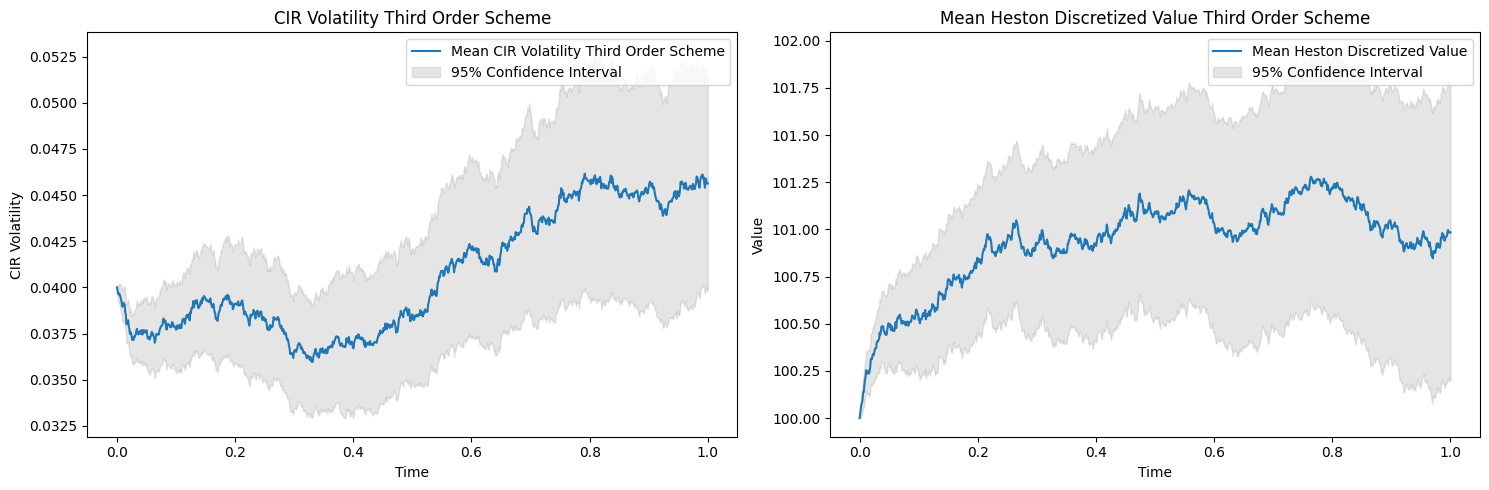

In [ ]:
def XCIR_0(t, x, k, a, sigma): return x * np.exp(-k * t) + (a - sigma ** 2 / 4) * psi_k(k, t)

def XCIR_1(t, x, k, a, sigma): return np.maximum(np.sqrt(x) + sigma / 2 * t, 0) ** 2

def X_tilde(t, x, k, a, sigma): return x + t * sigma / np.sqrt(2) * np.sqrt(np.abs(a - (sigma ** 2) / 4))

def generate_samples_Y(n): return np.random.choice([np.sqrt(3 + np.sqrt(6)), -np.sqrt(3 + np.sqrt(6)), np.sqrt(3 - np.sqrt(6)), -np.sqrt(3 - np.sqrt(6))], size=n, p=[(np.sqrt(6) - 2) / (4 * np.sqrt(6)), (np.sqrt(6) - 2) / (4 * np.sqrt(6)), 1/2 - (np.sqrt(6) - 2) / (4 * np.sqrt(6)), 1/2 - (np.sqrt(6) - 2) / (4 * np.sqrt(6))])

def generate_samples_espilon(n): return np.random.choice([-1, 1], size=n, p=[0.5, 0.5])

def generate_samples_zeta(n): return np.random.choice([1, 2, 3], size=n, p=[1/3, 1/3, 1/3])

def K3(t, sigma, a, k):
    psi = psi_k(-k, t)
    alpha = (np.sqrt(sigma ** 2 / 4 - a + sigma / np.sqrt(2) * np.sqrt(a - sigma ** 2 / 4)) + sigma / 2 * np.sqrt(3 + np.sqrt(6))) ** 2 if (4 * a > sigma ** 2 > 4 * a / 3) else \
            sigma / np.sqrt(2) * np.sqrt(a - sigma ** 2 / 4) if (sigma ** 2 <= 4 * a / 3) else \
            sigma ** 2 / 4 - a + (np.sqrt(sigma / np.sqrt(2) * np.sqrt(sigma ** 2 / 4 - a)) + sigma / 2 * np.sqrt(3 + np.sqrt(6))) ** 2
    return psi_k(-k, t) * alpha

def u_tilde_3(t, x, a, k, sigma): return u_tilde_1(t, x, a, k) * u_tilde_2(t, x, a, k, sigma) + sigma ** 2 * psi_k(k, t) * (2 * x ** 2 * np.exp(-2 * k * t) + psi_k(k, t) * (a + sigma ** 2 / 2) * (3 * x * np.exp(-k * t) + a * psi_k(k, t)))

def compute_pi_x_plus_minus(t, x, a, k, sigma):
    m1, m2, m3 = u_tilde_1(t, x, a, k), u_tilde_2(t, x, a, k, sigma), u_tilde_3(t, x, a, k, sigma)
    s, p = (m3 - m1 * m2) / (m2 - m1 ** 2), (m1 * m3 - m2 ** 2) / (m2 - m1 ** 2)
    delta = s ** 2 - 4 * p
    x_plus, x_minus = (s + np.sqrt(delta)) / 2, (s - np.sqrt(delta)) / 2
    pi = (m1 - x_minus) / (x_plus - x_minus)
    # print('compute_pi_x_plus_minus',x_plus, x_minus, pi)
    return x_plus, x_minus, pi

def X_hat_xk0(t, x, k, K3_t, Y, sigma, epsilon, zeta):
    temp, t, condition, mask_1, mask_2, mask_3, new_x = t, psi_k(-k, t), ((sigma ** 2) <= (4 * a)), (zeta == 1), (zeta == 2), (zeta == 3), np.zeros_like(x)

    if condition:
        if np.any(mask_1): new_x[mask_1] = X_tilde(epsilon[mask_1] * t, XCIR_0(t, XCIR_1(np.sqrt(t) * Y[mask_1], x[mask_1], k, a, sigma), k, a, sigma), k, a, sigma)
        if np.any(mask_2): new_x[mask_2] = XCIR_0(t, X_tilde(epsilon[mask_2] * t, XCIR_1(np.sqrt(t) * Y[mask_2], x[mask_2], k, a, sigma), k, a, sigma), k, a, sigma)
        if np.any(mask_3): new_x[mask_3] = XCIR_0(t, XCIR_1(np.sqrt(t) * Y[mask_3], X_tilde(epsilon[mask_3] * t, x[mask_3], k, a, sigma), k, a, sigma), k, a, sigma)
    else:
        if np.any(mask_1): new_x[mask_1] = X_tilde(epsilon[mask_1] * t, XCIR_1(np.sqrt(t) * Y[mask_1], XCIR_0(t, x[mask_1], k, a, sigma), k, a, sigma), k, a, sigma)
        if np.any(mask_2): new_x[mask_2] = XCIR_1(np.sqrt(t) * Y[mask_2], X_tilde(epsilon[mask_2] * t, XCIR_0(t, x[mask_2], k, a, sigma), k, a, sigma), k, a, sigma)
        if np.any(mask_3): new_x[mask_3] = XCIR_1(np.sqrt(t) * Y[mask_3], XCIR_0(t, X_tilde(epsilon[mask_3] * t, x[mask_3], k, a, sigma), k, a, sigma), k, a, sigma)
    # print('X_hat_xk0',np.exp(-k * temp) * new_x)
    return np.exp(-k * temp) * new_x

def generator_p_hat_x_3rdOrder(t, x, K3_t, sigma):
    U, mask_smaller = np.random.uniform(0, 1, size=x.shape), (x <= K3_t)
    x_plus, x_minus, pi = compute_pi_x_plus_minus(t, x, a, k, sigma)
    return np.where(mask_smaller, np.where(U <= pi, x_plus, x_minus), X_hat_xk0(t, x, k, K3_t, generate_samples_Y(len(x)), sigma, generate_samples_espilon(len(x)), generate_samples_zeta(len(x))))

def XCIR_3rdOrder(x_1, a, k, sigma, T, n, n_paths):
    paths, K3_t, dt = np.zeros((n_paths, n)), np.zeros((n_paths, n)), T / n
    paths[:, 0] = x_1
    # for i in range(1, n):
    #   result = generator_p_hat_x_3rdOrder(dt, paths[:, i-1], K3(dt, sigma, a, k), sigma)
    #   result[(result > 2*x_1) + (result < 0.5*x_1)] = x_1
    #   paths[:, i] = result
    for i in range(1, n):
      result = generator_p_hat_x_3rdOrder(dt, paths[:, i-1], K3(dt, sigma, a, k), sigma)
      mask = (result > 1.2*paths[:, i-1]) + (result < 0.8*paths[:, i-1])
      result[mask] = paths[:, i-1][mask]
      paths[:, i] = result
    return paths.T

n = int(1e3) #nombre de points
n_paths = int(1e3)

# Example usage:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the first graph with XCIR_3rdOrder
paths = XCIR_3rdOrder(X_01, a, k, sigma2, T, n, n_paths)
df_paths = pd.DataFrame(paths)
df_paths.index = np.linspace(0, 1, len(df_paths))
plot_with_confidence_intervals_subplot(axs[0], df_paths, xlabel='Time', ylabel='CIR Volatility', title='CIR Volatility Third Order Scheme', label='Mean CIR Volatility Third Order Scheme')

# Plot the second graph with XCIR_3rdOrder
df_test = pd.DataFrame(heston_scheme_discretized(X_01, X_03, k, a, sigma2, r, rho2, T, n, n_paths, XCIR_3rdOrder))
df_test.index = np.linspace(0, 1, len(df_test))
plot_with_confidence_intervals_subplot(axs[1], df_test, xlabel='Time', ylabel='Value', title='Mean Heston Discretized Value Third Order Scheme', label='Mean Heston Discretized Value')

plt.tight_layout()
plt.show()

In [ ]:
n = int(1e3) #nombre de points
n_paths = int(1e5)

# Define sigma and rho values
strike_prices = [S1, S2, S3]
sigma_values = [sigma1, sigma2]
rho_values = [rho1, rho2]

# Define the exotic option strike prices
exotic_K1, exotic_K2 = 80, 120

# Initialize lists to store data
sigma_list, rho_list, strike_price_list, asian_put_price_list, european_put_price_list, exotic_put_price_list = [], [], [], [], [], []
simulation_results, asian_put_prices, european_put_prices, exotic_put_prices = {}, {}, {}, {}

# Calculate option prices and simulation results for each sigma, rho, and strike price
for sigma, rho in zip(sigma_values,rho_values):
    # Simulate Heston model for the current sigma and rho values
    result_sigma_rho = heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, n, n_paths, XCIR_3rdOrder)
    # Store the simulation result for the current sigma and rho values
    simulation_results[(sigma, rho)] = result_sigma_rho

    # Initialize dictionaries for the current sigma and rho values
    asian_put_prices[(sigma, rho)] = {}
    european_put_prices[(sigma, rho)] = {}
    exotic_put_prices[(sigma, rho)] = {}

    # Calculate option prices for each strike price
    for K in strike_prices:
        # Asian put option prices
        asian_put_price = asian_put_option(result_sigma_rho, K, r, T)
        asian_put_prices[(sigma, rho)][K] = asian_put_option(result_sigma_rho, K, r, T)

        # European put option prices
        european_put_price = european_put_option(result_sigma_rho[-1, :], K, r, T)
        exotic_put_price = exotic_option(result_sigma_rho[-1, :], exotic_K1, exotic_K2, r, T)

        # European put option prices
        european_put_prices[(sigma, rho)][K] = european_put_option(result_sigma_rho[-1, :], K, r, T)
        exotic_put_prices[(sigma, rho)][K] = exotic_option(result_sigma_rho[-1, :], exotic_K1, exotic_K2, r, T)

        # Append data to lists
        sigma_list.append(sigma)
        rho_list.append(rho)
        strike_price_list.append(K)
        asian_put_price_list.append(asian_put_price)
        european_put_price_list.append(european_put_price)
        exotic_put_price_list.append(exotic_put_price)

# Construct the DataFrame
df = pd.DataFrame({
    'Sigma': sigma_list,
    'Rho': rho_list,
    'Strike Price': strike_price_list,
    'Asian Put Price': asian_put_price_list,
    'European Put Price': european_put_price_list,
    'Exotic Put Price': exotic_put_price_list
})

# Group by sigma and rho using pivot_table
grouped_df = df.pivot_table(index=['Sigma', 'Rho','Strike Price']).sort_index()

grouped_df

Asian Put Price  European Put Price  Exotic Put Price
Sigma Rho  Strike Price                                                       
0.4   -0.5 80                   0.140579            0.690584         24.880743
           100                  2.584067            3.372430         24.880743
           120                 16.780415           15.017788         24.880743
1.0   -0.8 80                   0.113678            0.620657         20.673858
           100                  2.457462            4.440167         20.673858
           120                 18.971148           19.154747         20.673858

# Scheme 3

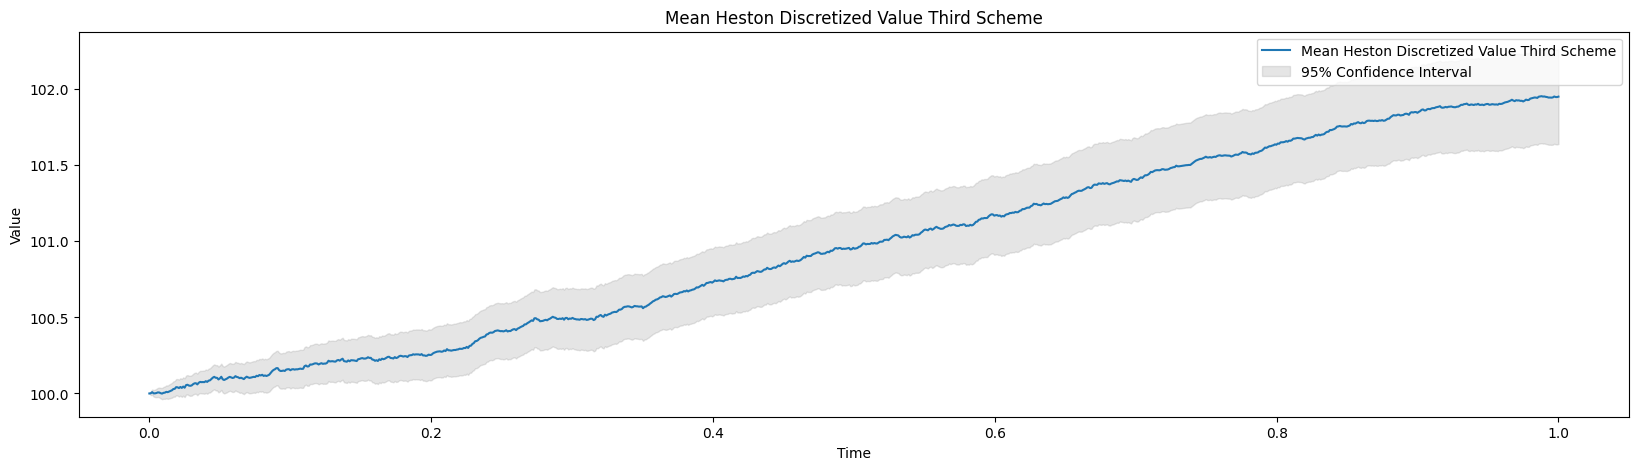

In [ ]:
# Function to simulate the Heston model
def heston_cir_model(X_01, X_03, k, a, sigma, r, rho, T, n, n_paths):
    X_1 = np.zeros((n, n_paths))
    X_1[0, :] = X_01
    X_2 = np.zeros((n, n_paths))
    X_2[0, :] = 0
    X_3 = np.zeros((n, n_paths))
    X_3[0, :] = X_03
    X_4 = np.zeros((n, n_paths))
    X_4[0, :] = 0
    dt = T / n
    Z = rng.normal(loc=0, scale=np.sqrt(dt), size=(2, n_paths*(n-1)))

    for j in range(n-1) :
      X_1[j+1, :] = X_1[j, :] + (a-k*np.maximum(X_1[j, :],0))*dt + sigma*np.sqrt(np.maximum(X_1[j, :],0))*Z[0, j*n_paths:(j+1)*n_paths]
      X_2[j+1, :] = X_2[j, :] + X_1[j, :]*dt
      X_3[j+1, :] = X_3[j, :] * np.exp((r - np.maximum(X_1[j, :],0)/2)*dt + np.sqrt(np.maximum(X_1[j, :],0)) * (rho * Z[0, j*n_paths:(j+1)*n_paths] + np.sqrt(1-rho**2) * Z[1, j*n_paths:(j+1)*n_paths]))
      X_4[j+1, :] = X_4[j, :] + X_3[j, :]*dt
    return X_3

n = int(1e3) #nombre de points
n_paths = int(1e4)

paths = heston_cir_model(X_01, X_03, k, a, sigma2, r, rho2, T, n, n_paths)
df_paths = pd.DataFrame(paths)
df_paths.index = np.linspace(0,1,n)
plot_with_confidence_intervals(df_paths, xlabel='Time', ylabel='Value', title='Mean Heston Discretized Value Third Scheme', label='Mean Heston Discretized Value Third Scheme')

In [ ]:
n = int(1e2) #nombre de points
n_paths = int(1e6)
# Define sigma and rho values
strike_prices = [S1, S2, S3]
sigma_values = [sigma1, sigma2]
rho_values = [rho1, rho2]

# Define the exotic option strike prices
exotic_K1, exotic_K2 = 80, 120

# Initialize lists to store data
sigma_list, rho_list, strike_price_list, asian_put_price_list, european_put_price_list, exotic_put_price_list = [], [], [], [], [], []
simulation_results, asian_put_prices, european_put_prices, exotic_put_prices = {}, {}, {}, {}

# Calculate option prices and simulation results for each sigma, rho, and strike price
for sigma, rho in zip(sigma_values,rho_values):
        # Simulate Heston model for the current sigma and rho values
        result_sigma_rho = heston_cir_model(X_01, X_03, k, a, sigma, r, rho, T, n, n_paths)
        # Store the simulation result for the current sigma and rho values
        simulation_results[(sigma, rho)] = result_sigma_rho

        # Initialize dictionaries for the current sigma and rho values
        asian_put_prices[(sigma, rho)] = {}
        european_put_prices[(sigma, rho)] = {}
        exotic_put_prices[(sigma, rho)] = {}

        # Calculate option prices for each strike price
        for K in strike_prices:
            # Asian put option prices
            asian_put_price = asian_put_option(result_sigma_rho, K, r, T)
            asian_put_prices[(sigma, rho)][K] = asian_put_option(result_sigma_rho, K, r, T)

            # European put option prices
            european_put_price = european_put_option(result_sigma_rho[-1, :], K, r, T)
            exotic_put_price = exotic_option(result_sigma_rho[-1, :], exotic_K1, exotic_K2, r, T)

            # European put option prices
            european_put_prices[(sigma, rho)][K] = european_put_option(result_sigma_rho[-1, :], K, r, T)
            exotic_put_prices[(sigma, rho)][K] = exotic_option(result_sigma_rho[-1, :], exotic_K1, exotic_K2, r, T)

            # Append data to lists
            sigma_list.append(sigma)
            rho_list.append(rho)
            strike_price_list.append(K)
            asian_put_price_list.append(asian_put_price)
            european_put_price_list.append(european_put_price)
            exotic_put_price_list.append(exotic_put_price)

# Construct the DataFrame
df = pd.DataFrame({
    'Sigma': sigma_list,
    'Rho': rho_list,
    'Strike Price': strike_price_list,
    'Asian Put Price': asian_put_price_list,
    'European Put Price': european_put_price_list,
    'Exotic Put Price': exotic_put_price_list
})

# Group by sigma and rho using pivot_table
grouped_df = df.pivot_table(index=['Sigma', 'Rho','Strike Price']).sort_index()

grouped_df

Asian Put Price  European Put Price  Exotic Put Price
Sigma Rho  Strike Price                                                       
0.4   -0.5 80                   0.257864            1.539132         21.725643
           100                  3.812497            6.137325         21.725643
           120                 18.803421           19.021436         21.725643
1.0   -0.8 80                   0.608122            1.729783         23.036090
           100                  3.015597            4.228986         23.036090
           120                 18.644506           17.901640         23.036090

# **Figure 1 Reproduction**

Reproduisons la figure 1 du papier de A. Alfonsi.

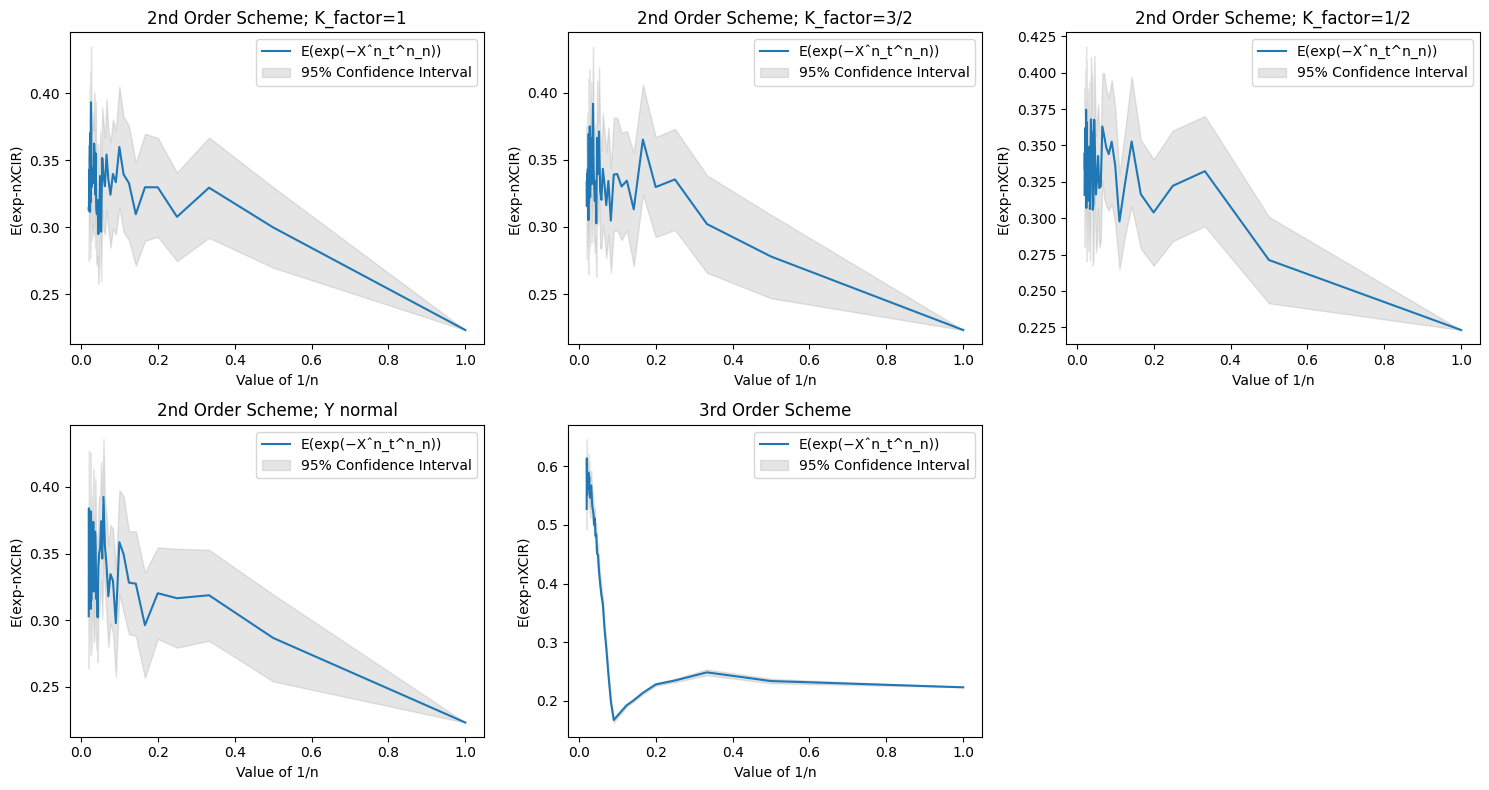

In [ ]:
df_paths_fig1_2ndOrder_K_factor_1, df_paths_fig1_2ndOrder_K_factor_3divided2, df_paths_fig1_2ndOrder_K_factor_1divided2, df_paths_fig1_2ndOrder_YNormal, df_paths_fig1_3rdOrder = dict(), dict(),dict(), dict(),dict()

n_paths = int(1e2)
list_number = range(1,50)
index_numbers = [1/number for number in list_number]

for number in list_number:
  df_paths_fig1_2ndOrder_K_factor_1[str(number)] = np.exp(-XCIR_2ndOrder(x_1=3/2, a=1/2, k=1/2, sigma=0.8, T=T, n=number, n_paths=n_paths, K_factor=1)[-1])
  df_paths_fig1_2ndOrder_K_factor_3divided2[str(number)] = np.exp(-XCIR_2ndOrder(x_1=3/2, a=1/2, k=1/2, sigma=0.8, T=T, n=number, n_paths=n_paths, K_factor=3/2)[-1])
  df_paths_fig1_2ndOrder_K_factor_1divided2[str(number)] = np.exp(-XCIR_2ndOrder(x_1=3/2, a=1/2, k=1/2, sigma=0.8, T=T, n=number, n_paths=n_paths, K_factor=1/2)[-1])
  df_paths_fig1_2ndOrder_YNormal[str(number)] = np.exp(-XCIR_2ndOrder(x_1=3/2, a=1/2, k=1/2, sigma=0.8, T=T, n=number, n_paths=n_paths, Normal=True)[-1])
  df_paths_fig1_3rdOrder[str(number)] = np.exp(-XCIR_3rdOrder(x_1=3/2, a=1/2, k=1/2, sigma=0.8, T=T, n=number, n_paths=n_paths)[-1])

df_fig1_2ndOrder_K_factor_1 = pd.DataFrame(np.array(list(df_paths_fig1_2ndOrder_K_factor_1.values())), index=index_numbers)
df_fig1_2ndOrder_K_factor_3divided2 = pd.DataFrame(np.array(list(df_paths_fig1_2ndOrder_K_factor_3divided2.values())), index=index_numbers)
df_fig1_2ndOrder_K_factor_1divided2 = pd.DataFrame(np.array(list(df_paths_fig1_2ndOrder_K_factor_1divided2.values())), index=index_numbers)
df_fig1_2ndOrder_YNormal = pd.DataFrame(np.array(list(df_paths_fig1_2ndOrder_YNormal.values())), index=index_numbers)
df_fig1_3rdOrder = pd.DataFrame(np.array(list(df_paths_fig1_3rdOrder.values())), index=index_numbers)

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Plot each dataframe on a separate subplot
plot_with_confidence_intervals_subplot(axs[0, 0], df_fig1_2ndOrder_K_factor_1, xlabel='Value of 1/n', ylabel='E(exp-nXCIR)', title='2nd Order Scheme; K_factor=1', label='E(exp(−Xˆn_t^n_n))')
plot_with_confidence_intervals_subplot(axs[0, 1], df_fig1_2ndOrder_K_factor_3divided2, xlabel='Value of 1/n', ylabel='E(exp-nXCIR)', title='2nd Order Scheme; K_factor=3/2', label='E(exp(−Xˆn_t^n_n))')
plot_with_confidence_intervals_subplot(axs[0, 2], df_fig1_2ndOrder_K_factor_1divided2, xlabel='Value of 1/n', ylabel='E(exp-nXCIR)', title='2nd Order Scheme; K_factor=1/2', label='E(exp(−Xˆn_t^n_n))')
plot_with_confidence_intervals_subplot(axs[1, 0], df_fig1_2ndOrder_YNormal, xlabel='Value of 1/n', ylabel='E(exp-nXCIR)', title='2nd Order Scheme; Y normal', label='E(exp(−Xˆn_t^n_n))')
plot_with_confidence_intervals_subplot(axs[1, 1], df_fig1_3rdOrder, xlabel='Value of 1/n', ylabel='E(exp-nXCIR)', title='3rd Order Scheme', label='E(exp(−Xˆn_t^n_n))')
fig.delaxes(axs[1, 2])

# Adjust layout
plt.tight_layout()
plt.show()

<ipython-input-22-d18659d675e4>:24: RuntimeWarning: divide by zero encountered in divide
  density_1, density_2, U = u_tilde_1(t, x[mask_1], a, k) / (2 * pi_val), u_tilde_1(t, x[mask_1], a, k) / (2 * (1 - pi_val)), np.random.uniform(0, 1, size=np.sum(mask_1))
<ipython-input-22-d18659d675e4>:25: RuntimeWarning: invalid value encountered in multiply
  new_x[mask_1] = density_1 * (U <= pi_val) + density_2 * (U > pi_val)


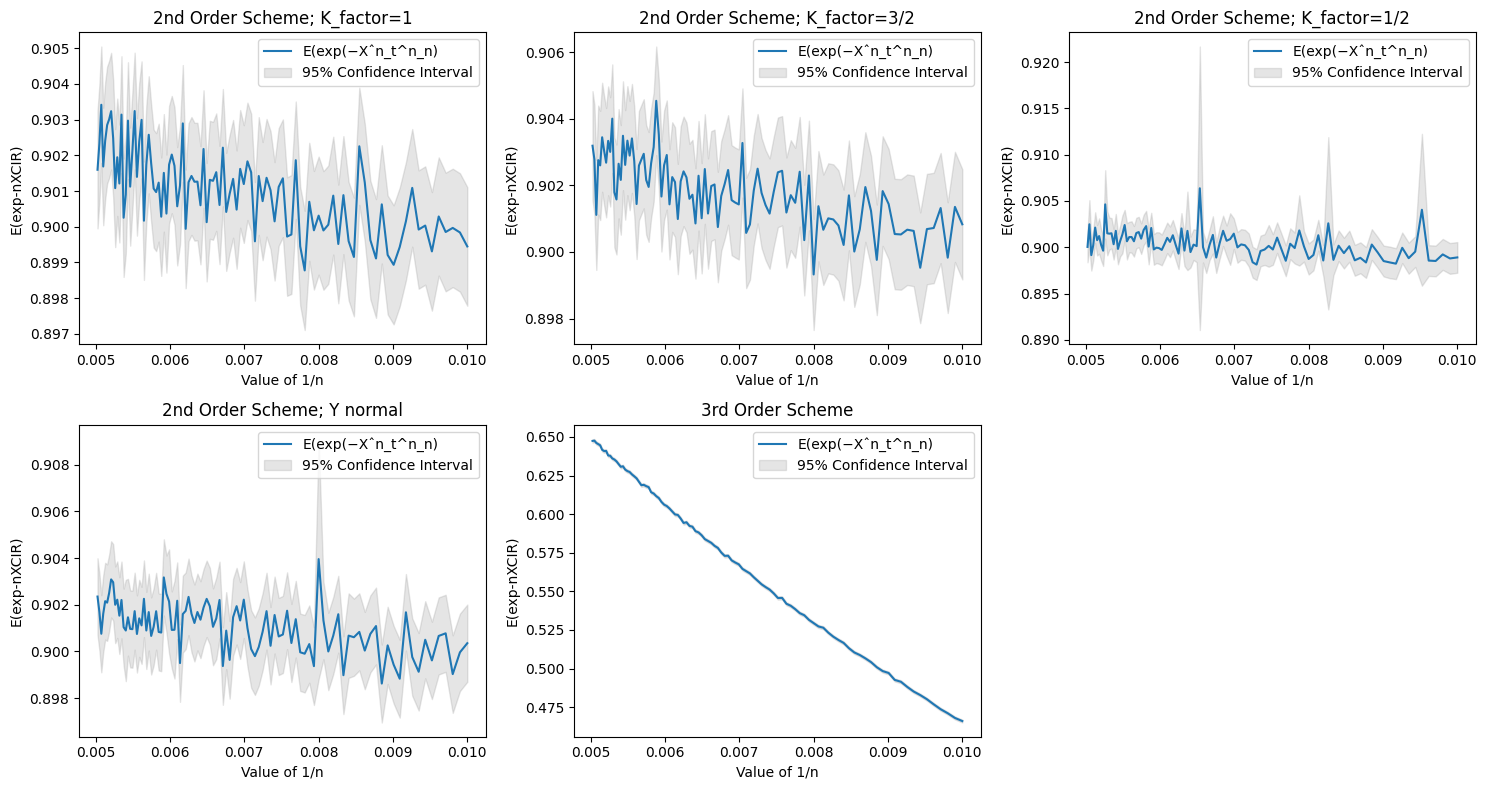

In [ ]:
df_paths_fig1_2ndOrder_K_factor_1, df_paths_fig1_2ndOrder_K_factor_3divided2, df_paths_fig1_2ndOrder_K_factor_1divided2, df_paths_fig1_2ndOrder_YNormal, df_paths_fig1_3rdOrder = dict(), dict(),dict(), dict(),dict()
for number in list_number:
  df_paths_fig1_2ndOrder_K_factor_1[str(number)] = np.exp(-XCIR_2ndOrder(x_1=0.3, a=0.04, k=0.1, sigma=2, T=T, n=number, n_paths=n_paths, K_factor=1)[-1])
  df_paths_fig1_2ndOrder_K_factor_3divided2[str(number)] = np.exp(-XCIR_2ndOrder(x_1=0.3, a=0.04, k=0.1, sigma=2, T=T, n=number, n_paths=n_paths, K_factor=3/2)[-1])
  df_paths_fig1_2ndOrder_K_factor_1divided2[str(number)] = np.exp(-XCIR_2ndOrder(x_1=0.3, a=0.04, k=0.1, sigma=2, T=T, n=number, n_paths=n_paths, K_factor=1/2)[-1])
  df_paths_fig1_2ndOrder_YNormal[str(number)] = np.exp(-XCIR_2ndOrder(x_1=0.3, a=0.04, k=0.1, sigma=2, T=T, n=number, n_paths=n_paths, Normal=True)[-1])
  df_paths_fig1_3rdOrder[str(number)] = np.exp(-XCIR_3rdOrder(x_1=0.3, a=0.04, k=0.1, sigma=2, T=T, n=number, n_paths=n_paths)[-1])

df_fig1_2ndOrder_K_factor_1 = pd.DataFrame(np.array(list(df_paths_fig1_2ndOrder_K_factor_1.values())), index=index_numbers)
df_fig1_2ndOrder_K_factor_3divided2 = pd.DataFrame(np.array(list(df_paths_fig1_2ndOrder_K_factor_3divided2.values())), index=index_numbers)
df_fig1_2ndOrder_K_factor_1divided2 = pd.DataFrame(np.array(list(df_paths_fig1_2ndOrder_K_factor_1divided2.values())), index=index_numbers)
df_fig1_2ndOrder_YNormal = pd.DataFrame(np.array(list(df_paths_fig1_2ndOrder_YNormal.values())), index=index_numbers)
df_fig1_3rdOrder = pd.DataFrame(np.array(list(df_paths_fig1_3rdOrder.values())), index=index_numbers)

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Plot each dataframe on a separate subplot
plot_with_confidence_intervals_subplot(axs[0, 0], df_fig1_2ndOrder_K_factor_1, xlabel='Value of 1/n', ylabel='E(exp-nXCIR)', title='2nd Order Scheme; K_factor=1', label='E(exp(−Xˆn_t^n_n)')
plot_with_confidence_intervals_subplot(axs[0, 1], df_fig1_2ndOrder_K_factor_3divided2, xlabel='Value of 1/n', ylabel='E(exp-nXCIR)', title='2nd Order Scheme; K_factor=3/2', label='E(exp(−Xˆn_t^n_n)')
plot_with_confidence_intervals_subplot(axs[0, 2], df_fig1_2ndOrder_K_factor_1divided2, xlabel='Value of 1/n', ylabel='E(exp-nXCIR)', title='2nd Order Scheme; K_factor=1/2', label='E(exp(−Xˆn_t^n_n)')
plot_with_confidence_intervals_subplot(axs[1, 0], df_fig1_2ndOrder_YNormal, xlabel='Value of 1/n', ylabel='E(exp-nXCIR)', title='2nd Order Scheme; Y normal', label='E(exp(−Xˆn_t^n_n)')
plot_with_confidence_intervals_subplot(axs[1, 1], df_fig1_3rdOrder, xlabel='Value of 1/n', ylabel='E(exp-nXCIR)', title='3rd Order Scheme', label='E(exp(−Xˆn_t^n_n)')
fig.delaxes(axs[1, 2])

# Adjust layout
plt.tight_layout()
plt.show()

# **Figure 2 Reproduction**

Reproduisons la figure 2 du papier de A. Alfonsi.

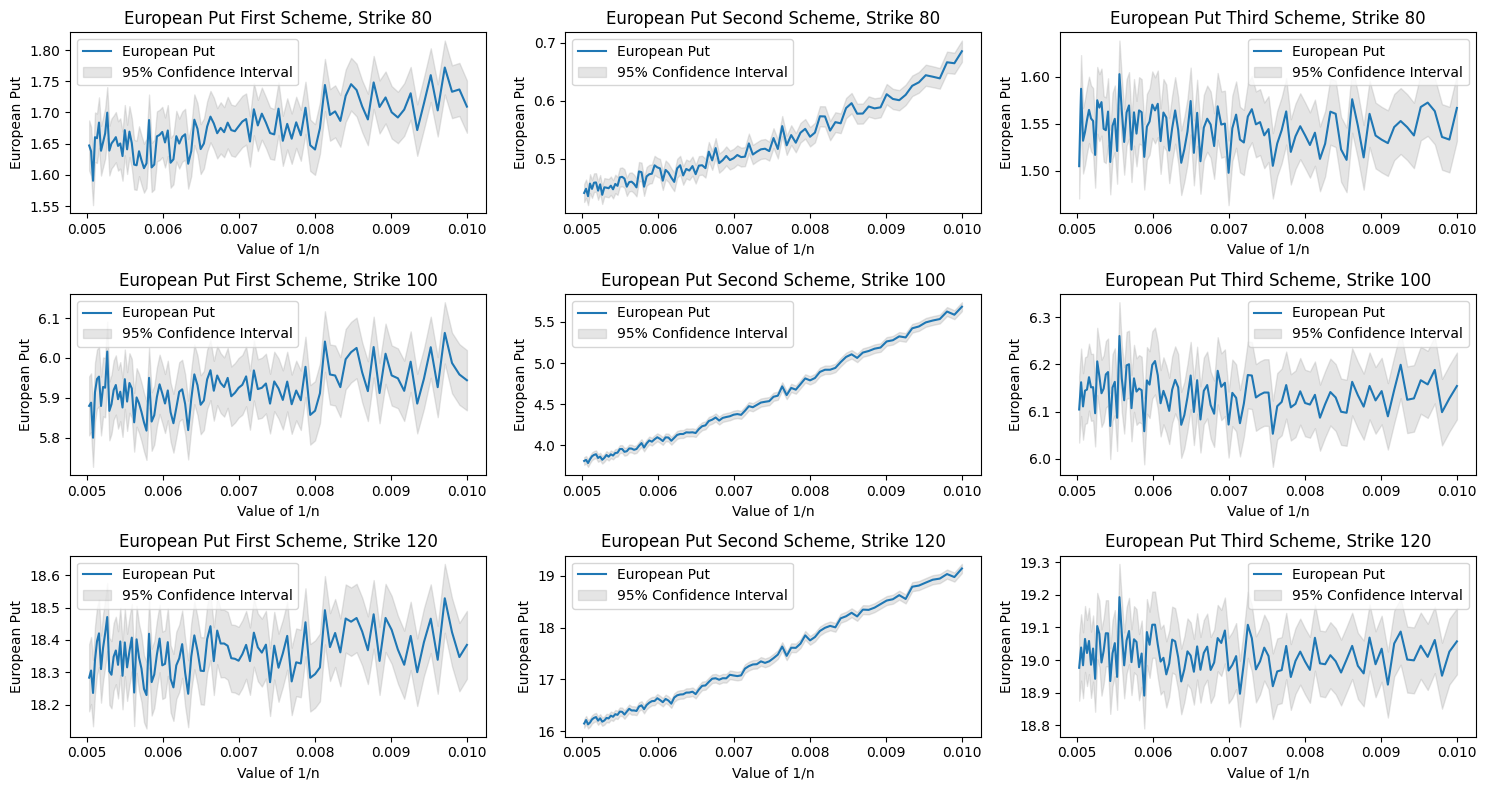

In [ ]:
# Set parameters
X_01, X_03 = 0.04, 100
k = 0.5
a = 0.02
sigma = 0.4
r = 0.02
rho = -0.5
T = 1
S1, S2, S3 = 80, 100, 120
n_paths = int(1e5)

df_paths_fig2_1stScheme_S1, df_paths_fig2_2ndScheme_S1, df_paths_fig2_3rdScheme_S1 = dict(), dict(),dict()
df_paths_fig2_1stScheme_S2, df_paths_fig2_2ndScheme_S2, df_paths_fig2_3rdScheme_S2 = dict(), dict(),dict()
df_paths_fig2_1stScheme_S3, df_paths_fig2_2ndScheme_S3, df_paths_fig2_3rdScheme_S3 = dict(), dict(),dict()

for number in list_number:
  Scheme_1 = heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths, XCIR_2ndOrder)
  Scheme_2 = heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths, XCIR_3rdOrder)
  Scheme_3 = pd.DataFrame(heston_cir_model(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths))

  df_paths_fig2_1stScheme_S1[str(number)] = np.maximum(0,np.exp(-r) * (S1 - Scheme_1[-1, :]))
  df_paths_fig2_2ndScheme_S1[str(number)] = np.maximum(0,np.exp(-r) * (S1 - Scheme_2[-1, :]))
  df_paths_fig2_3rdScheme_S1[str(number)] = np.maximum(0,np.exp(-r) * (S1 - Scheme_3.iloc[-1, :]))

  df_paths_fig2_1stScheme_S2[str(number)] = np.maximum(0,np.exp(-r) * (S2 - Scheme_1[-1, :]))
  df_paths_fig2_2ndScheme_S2[str(number)] = np.maximum(0,np.exp(-r) * (S2 - Scheme_2[-1, :]))
  df_paths_fig2_3rdScheme_S2[str(number)] = np.maximum(0,np.exp(-r) * (S2 - Scheme_3.iloc[-1, :]))

  df_paths_fig2_1stScheme_S3[str(number)] = np.maximum(0,np.exp(-r) * (S3 - Scheme_1[-1, :]))
  df_paths_fig2_2ndScheme_S3[str(number)] = np.maximum(0,np.exp(-r) * (S3 - Scheme_2[-1, :]))
  df_paths_fig2_3rdScheme_S3[str(number)] = np.maximum(0,np.exp(-r) * (S3 - Scheme_3.iloc[-1, :]))

df_fig2_1stScheme_S1 = pd.DataFrame(np.array(list(df_paths_fig2_1stScheme_S1.values())), index=index_numbers)
df_fig2_2ndScheme_S1 = pd.DataFrame(np.array(list(df_paths_fig2_2ndScheme_S1.values())), index=index_numbers)
df_fig2_3rdScheme_S1 = pd.DataFrame(np.array(list(df_paths_fig2_3rdScheme_S1.values())), index=index_numbers)

df_fig2_1stScheme_S2 = pd.DataFrame(np.array(list(df_paths_fig2_1stScheme_S2.values())), index=index_numbers)
df_fig2_2ndScheme_S2 = pd.DataFrame(np.array(list(df_paths_fig2_2ndScheme_S2.values())), index=index_numbers)
df_fig2_3rdScheme_S2 = pd.DataFrame(np.array(list(df_paths_fig2_3rdScheme_S2.values())), index=index_numbers)

df_fig2_1stScheme_S3 = pd.DataFrame(np.array(list(df_paths_fig2_1stScheme_S3.values())), index=index_numbers)
df_fig2_2ndScheme_S3 = pd.DataFrame(np.array(list(df_paths_fig2_2ndScheme_S3.values())), index=index_numbers)
df_fig2_3rdScheme_S3 = pd.DataFrame(np.array(list(df_paths_fig2_3rdScheme_S3.values())), index=index_numbers)


# Create subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))

plot_with_confidence_intervals_subplot(axs[0, 0], df_fig2_1stScheme_S1, xlabel='Value of 1/n', ylabel='European Put', title='European Put First Scheme, Strike 80', label='European Put')
plot_with_confidence_intervals_subplot(axs[0, 1], df_fig2_2ndScheme_S1, xlabel='Value of 1/n', ylabel='European Put', title='European Put Second Scheme, Strike 80', label='European Put')
plot_with_confidence_intervals_subplot(axs[0, 2], df_fig2_3rdScheme_S1, xlabel='Value of 1/n', ylabel='European Put', title='European Put Third Scheme, Strike 80', label='European Put')

plot_with_confidence_intervals_subplot(axs[1, 0], df_fig2_1stScheme_S2, xlabel='Value of 1/n', ylabel='European Put', title='European Put First Scheme, Strike 100', label='European Put')
plot_with_confidence_intervals_subplot(axs[1, 1], df_fig2_2ndScheme_S2, xlabel='Value of 1/n', ylabel='European Put', title='European Put Second Scheme, Strike 100', label='European Put')
plot_with_confidence_intervals_subplot(axs[1, 2], df_fig2_3rdScheme_S2, xlabel='Value of 1/n', ylabel='European Put', title='European Put Third Scheme, Strike 100', label='European Put')

plot_with_confidence_intervals_subplot(axs[2, 0], df_fig2_1stScheme_S3, xlabel='Value of 1/n', ylabel='European Put', title='European Put First Scheme, Strike 120', label='European Put')
plot_with_confidence_intervals_subplot(axs[2, 1], df_fig2_2ndScheme_S3, xlabel='Value of 1/n', ylabel='European Put', title='European Put Second Scheme, Strike 120', label='European Put')
plot_with_confidence_intervals_subplot(axs[2, 2], df_fig2_3rdScheme_S3, xlabel='Value of 1/n', ylabel='European Put', title='European Put Third Scheme, Strike 120', label='European Put')

# Adjust layout
plt.tight_layout()
plt.show()

# **Figure 3 Reproduction**

Reproduisons la figure 3 du papier de A. Alfonsi.

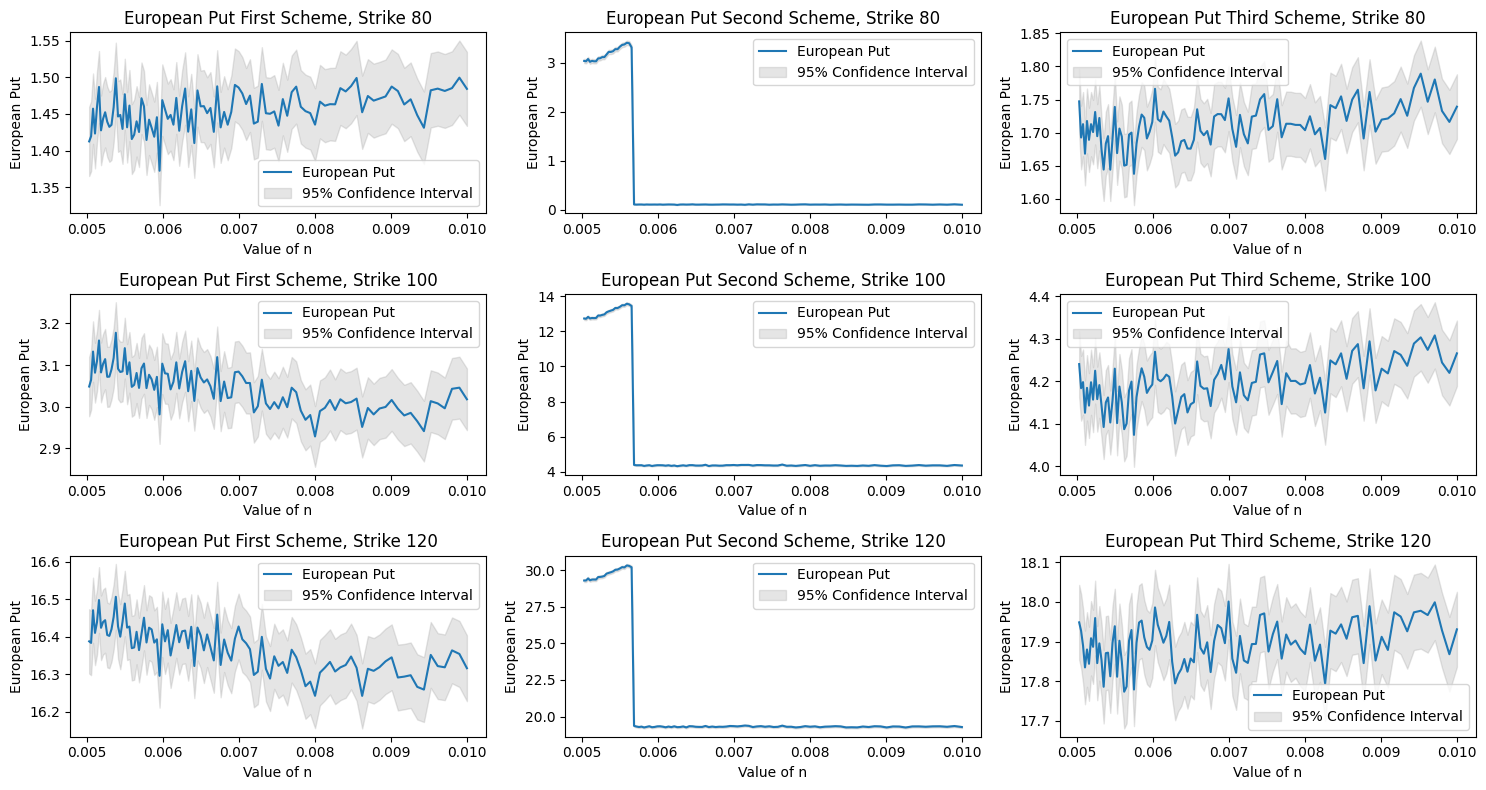

In [ ]:
# Set parameters
X_01, X_03 = 0.04, 100
k = 0.5
a = 0.02
sigma = 1
r = 0.02
rho = -0.8
T = 1
S1, S2, S3 = 80, 100, 120

df_paths_fig2_1stScheme_S1, df_paths_fig2_2ndScheme_S1, df_paths_fig2_3rdScheme_S1 = dict(), dict(),dict()
df_paths_fig2_1stScheme_S2, df_paths_fig2_2ndScheme_S2, df_paths_fig2_3rdScheme_S2 = dict(), dict(),dict()
df_paths_fig2_1stScheme_S3, df_paths_fig2_2ndScheme_S3, df_paths_fig2_3rdScheme_S3 = dict(), dict(),dict()

for number in list_number:
  Scheme_1 = heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths, XCIR_2ndOrder)
  Scheme_2 = heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths, XCIR_3rdOrder)
  Scheme_3 = pd.DataFrame(heston_cir_model(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths))

  df_paths_fig2_1stScheme_S1[str(number)] = np.maximum(0,np.exp(-r) * (S1 - Scheme_1[-1, :]))
  df_paths_fig2_2ndScheme_S1[str(number)] = np.maximum(0,np.exp(-r) * (S1 - Scheme_2[-1, :]))
  df_paths_fig2_3rdScheme_S1[str(number)] = np.maximum(0,np.exp(-r) * (S1 - Scheme_3.iloc[-1, :]))

  df_paths_fig2_1stScheme_S2[str(number)] = np.maximum(0,np.exp(-r) * (S2 - Scheme_1[-1, :]))
  df_paths_fig2_2ndScheme_S2[str(number)] = np.maximum(0,np.exp(-r) * (S2 - Scheme_2[-1, :]))
  df_paths_fig2_3rdScheme_S2[str(number)] = np.maximum(0,np.exp(-r) * (S2 - Scheme_3.iloc[-1, :]))

  df_paths_fig2_1stScheme_S3[str(number)] = np.maximum(0,np.exp(-r) * (S3 - Scheme_1[-1, :]))
  df_paths_fig2_2ndScheme_S3[str(number)] = np.maximum(0,np.exp(-r) * (S3 - Scheme_2[-1, :]))
  df_paths_fig2_3rdScheme_S3[str(number)] = np.maximum(0,np.exp(-r) * (S3 - Scheme_3.iloc[-1, :]))

df_fig2_1stScheme_S1 = pd.DataFrame(np.array(list(df_paths_fig2_1stScheme_S1.values())), index=index_numbers)
df_fig2_2ndScheme_S1 = pd.DataFrame(np.array(list(df_paths_fig2_2ndScheme_S1.values())), index=index_numbers)
df_fig2_3rdScheme_S1 = pd.DataFrame(np.array(list(df_paths_fig2_3rdScheme_S1.values())), index=index_numbers)

df_fig2_1stScheme_S2 = pd.DataFrame(np.array(list(df_paths_fig2_1stScheme_S2.values())), index=index_numbers)
df_fig2_2ndScheme_S2 = pd.DataFrame(np.array(list(df_paths_fig2_2ndScheme_S2.values())), index=index_numbers)
df_fig2_3rdScheme_S2 = pd.DataFrame(np.array(list(df_paths_fig2_3rdScheme_S2.values())), index=index_numbers)

df_fig2_1stScheme_S3 = pd.DataFrame(np.array(list(df_paths_fig2_1stScheme_S3.values())), index=index_numbers)
df_fig2_2ndScheme_S3 = pd.DataFrame(np.array(list(df_paths_fig2_2ndScheme_S3.values())), index=index_numbers)
df_fig2_3rdScheme_S3 = pd.DataFrame(np.array(list(df_paths_fig2_3rdScheme_S3.values())), index=index_numbers)

# Create subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))

plot_with_confidence_intervals_subplot(axs[0, 0], df_fig2_1stScheme_S1, xlabel='Value of n', ylabel='European Put', title='European Put First Scheme, Strike 80', label='European Put')
plot_with_confidence_intervals_subplot(axs[0, 1], df_fig2_2ndScheme_S1, xlabel='Value of n', ylabel='European Put', title='European Put Second Scheme, Strike 80', label='European Put')
plot_with_confidence_intervals_subplot(axs[0, 2], df_fig2_3rdScheme_S1, xlabel='Value of n', ylabel='European Put', title='European Put Third Scheme, Strike 80', label='European Put')

plot_with_confidence_intervals_subplot(axs[1, 0], df_fig2_1stScheme_S2, xlabel='Value of n', ylabel='European Put', title='European Put First Scheme, Strike 100', label='European Put')
plot_with_confidence_intervals_subplot(axs[1, 1], df_fig2_2ndScheme_S2, xlabel='Value of n', ylabel='European Put', title='European Put Second Scheme, Strike 100', label='European Put')
plot_with_confidence_intervals_subplot(axs[1, 2], df_fig2_3rdScheme_S2, xlabel='Value of n', ylabel='European Put', title='European Put Third Scheme, Strike 100', label='European Put')

plot_with_confidence_intervals_subplot(axs[2, 0], df_fig2_1stScheme_S3, xlabel='Value of n', ylabel='European Put', title='European Put First Scheme, Strike 120', label='European Put')
plot_with_confidence_intervals_subplot(axs[2, 1], df_fig2_2ndScheme_S3, xlabel='Value of n', ylabel='European Put', title='European Put Second Scheme, Strike 120', label='European Put')
plot_with_confidence_intervals_subplot(axs[2, 2], df_fig2_3rdScheme_S3, xlabel='Value of n', ylabel='European Put', title='European Put Third Scheme, Strike 120', label='European Put')

# Adjust layout
plt.tight_layout()
plt.show()

# **Figure 4 Reproduction**

Reproduisons la figure 4 du papier de A. Alfonsi.

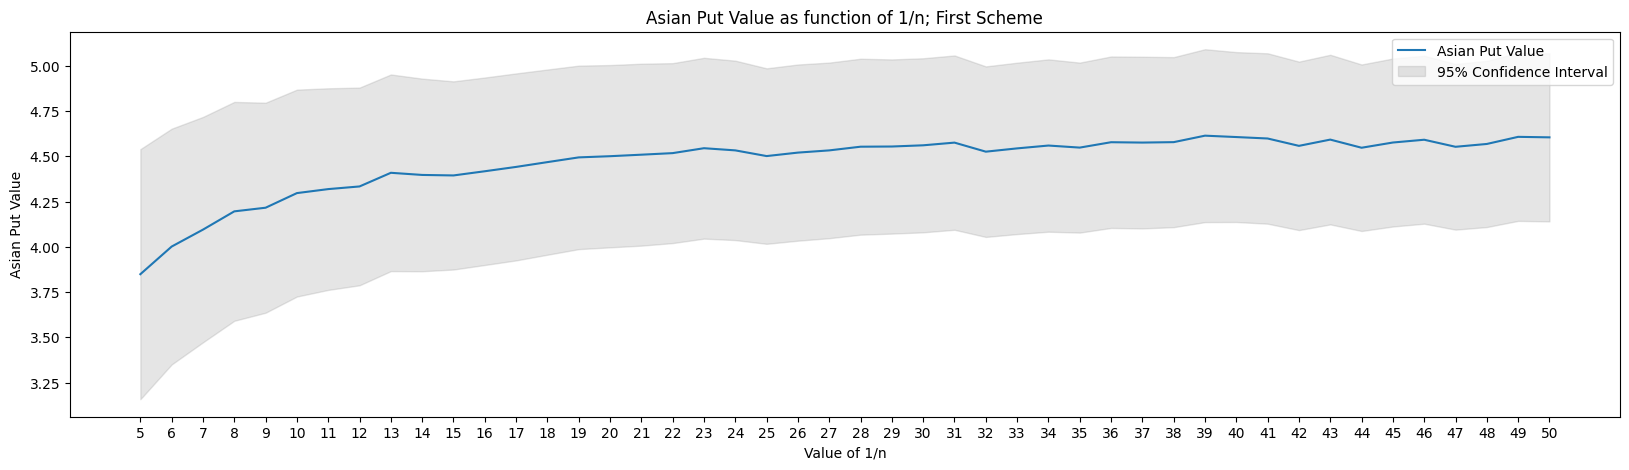

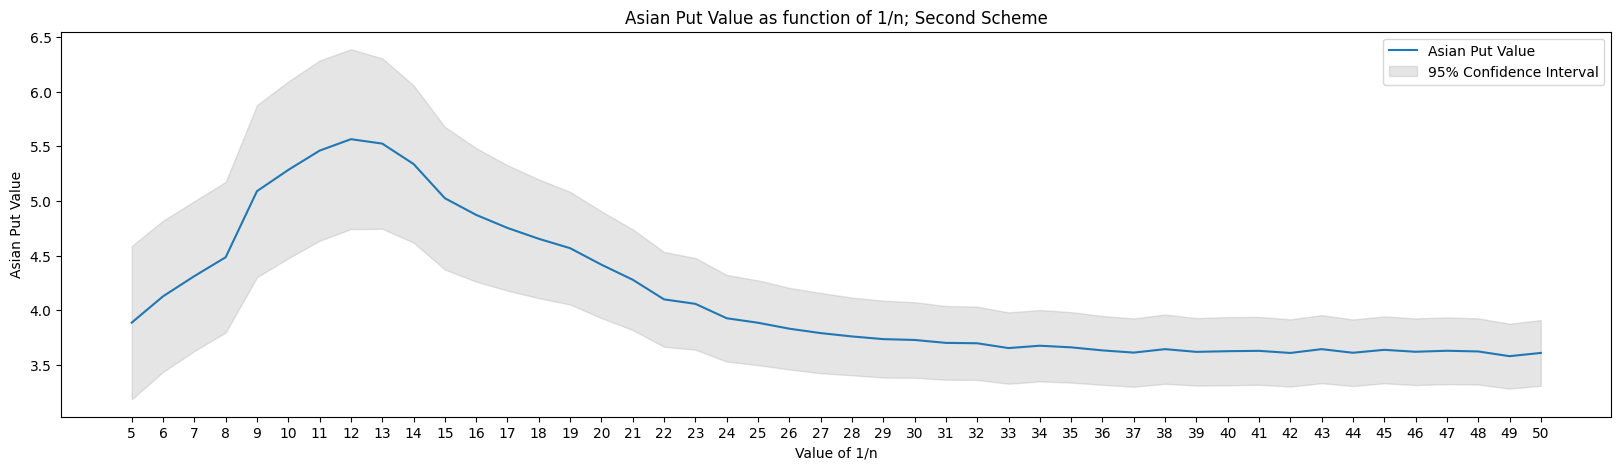

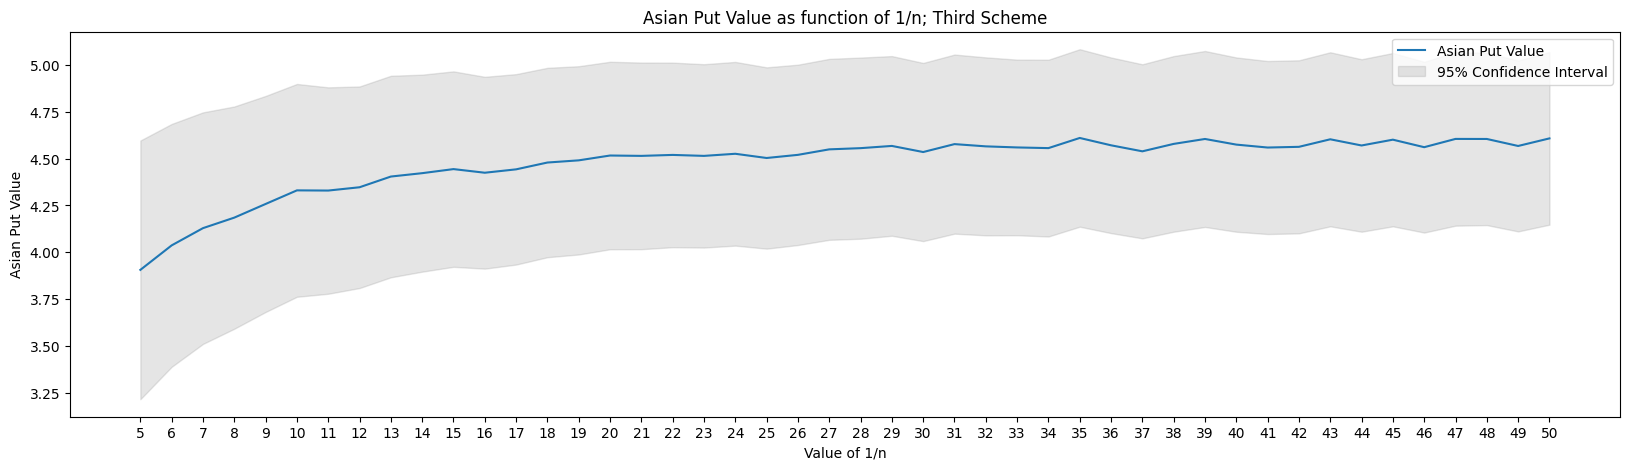

In [ ]:
df_paths_fig2_1stScheme, df_paths_fig2_2ndScheme, df_paths_fig2_3rdScheme = dict(), dict(),dict()
X_01=0.04
X_03=100
k=0.5
a=0.02
sigma=0.2
r=0.02
rho=-0.3
T=1

n_paths = int(1e5)
list_number = range(5,51)
index_numbers = [1/number for number in list_number]

for number in list_number:
  Scheme_1 = pd.DataFrame(heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths, XCIR_2ndOrder))
  Scheme_2 = pd.DataFrame(heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths, XCIR_3rdOrder))
  Scheme_3 = pd.DataFrame(heston_cir_model(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths))

  df_paths_fig2_1stScheme[str(number)] = np.maximum(0,np.exp(-r)*(100-Scheme_1)).mean(axis=1)
  df_paths_fig2_2ndScheme[str(number)] = np.maximum(0,np.exp(-r)*(100-Scheme_2)).mean(axis=1)
  df_paths_fig2_3rdScheme[str(number)] = np.maximum(0,np.exp(-r)*(100-Scheme_3)).mean(axis=1)

df_paths_fig2_1stScheme = pd.DataFrame(df_paths_fig2_1stScheme).T
df_paths_fig2_2ndScheme = pd.DataFrame(df_paths_fig2_2ndScheme).T
df_paths_fig2_3rdScheme = pd.DataFrame(df_paths_fig2_3rdScheme).T

plot_with_confidence_intervals(df_paths_fig2_1stScheme, xlabel='Value of 1/n', ylabel='Asian Put Value', title='Asian Put Value as function of 1/n; First Scheme', label='Asian Put Value')
plot_with_confidence_intervals(df_paths_fig2_2ndScheme, xlabel='Value of 1/n', ylabel='Asian Put Value', title='Asian Put Value as function of 1/n; Second Scheme', label='Asian Put Value')
plot_with_confidence_intervals(df_paths_fig2_3rdScheme, xlabel='Value of 1/n', ylabel='Asian Put Value', title='Asian Put Value as function of 1/n; Third Scheme', label='Asian Put Value')

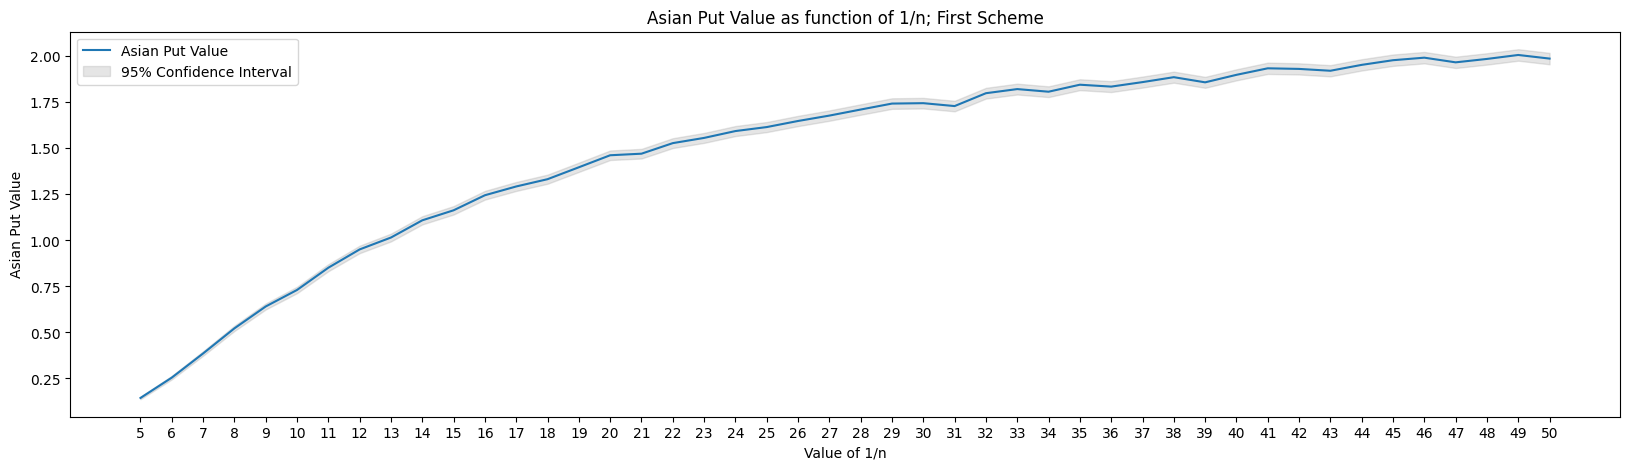

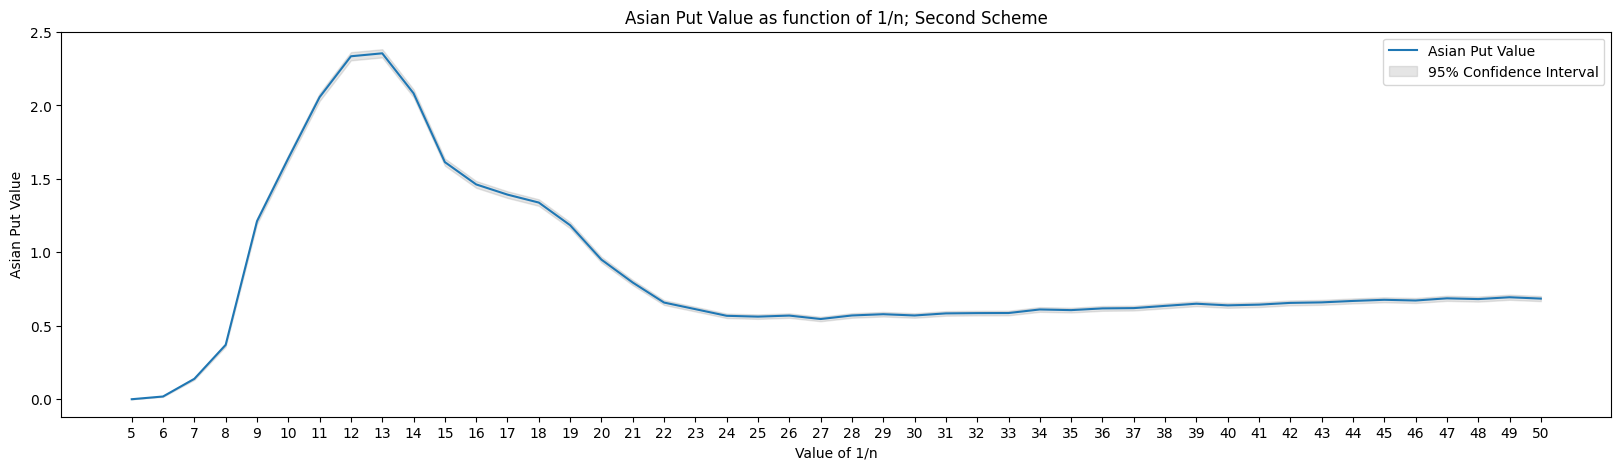

In [ ]:
# Function to simulate the Heston model
def heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, n, n_paths, XCIR):
    temp, X_1, X_2, X_3, X_4 = np.zeros((n, n_paths)), np.zeros((n, n_paths)), np.zeros((n, n_paths)), np.zeros((n, n_paths)), np.zeros((n, n_paths))
    X_1[0, :], X_2[0, :], X_3[0, :], X_4[0, :] = X_01, 0, X_03, 0
    dt = T/n
    Z = rng.normal(loc=0, scale=1, size=(n, n_paths))
    # Z = generate_samples((n, n_paths))
    temp = XCIR(X_01, a, k, sigma, T, n, n_paths)

    for j in range(n-1):
      X_1[j+1, :] = temp[j, :]
      X_2[j+1, :] = X_2[j, :] + 0.5 * (X_1[j, :] + temp[j, :]) * dt
      # X_3[j+1, :] = (X_3[j, :] * np.exp((r - rho * a / sigma) * dt + 0.5 * dt * (X_1[j, :] + temp[j, :]) * (k * rho / sigma - 0.5) + (rho / sigma) * (temp[j, :] - X_1[j, :])))
      X_3[j+1, :] = (X_3[j, :] * np.exp((r - rho * a / sigma) * dt + 0.5 * dt * (X_1[j, :] + temp[j, :]) * (k * rho / sigma - 0.5) + (rho / sigma) * (temp[j, :] - X_1[j, :]))) * np.exp(np.sqrt(dt * X_1[j, :] * (1 - rho**2)) * Z[j, :])
      X_4[j+1, :] = X_4[j, :] + 0.5 * dt * X_3[j, :] * (1 + np.exp((r - rho * a / sigma) * dt + 0.5 * dt * (X_1[j, :] + temp[j, :]) * (k * rho / sigma - 0.5)  + (rho / sigma) * (temp[j, :] - X_1[j, :])))

    return X_2, X_3, X_4

df_paths_fig2_1stScheme, df_paths_fig2_2ndScheme, df_paths_fig2_3rdScheme = dict(), dict(),dict()
X_01=0.04
X_03=100
k=0.5
a=0.02
sigma=0.2
r=0.02
rho=-0.3
T=1

n_paths = int(1e5)
list_number = range(5,51)
index_numbers = [1/number for number in list_number]

for number in list_number:
  Scheme_1 = heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths, XCIR_2ndOrder)
  Scheme_2 = heston_scheme_discretized(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths, XCIR_3rdOrder)
  # Scheme_3 = pd.DataFrame(heston_cir_model(X_01, X_03, k, a, sigma, r, rho, T, number, n_paths))

  df_paths_fig2_1stScheme[str(number)] = np.maximum(0,np.exp(-r) * (Scheme_1[0]>(a/k)) *(Scheme_1[2]-Scheme_1[1]))[-1]
  df_paths_fig2_2ndScheme[str(number)] = np.maximum(0,np.exp(-r) * (Scheme_2[0]>(a/k)) *(Scheme_2[2]-Scheme_2[1]))[-1]
  # df_paths_fig2_3rdScheme[str(number)] = np.maximum(0,np.exp(-r) * (Scheme_3[0]>(a/k)) *(Scheme_3[2]-Scheme_3[1])).iloc[-1]

df_paths_fig2_1stScheme = pd.DataFrame(df_paths_fig2_1stScheme).T
df_paths_fig2_2ndScheme = pd.DataFrame(df_paths_fig2_2ndScheme).T
# df_paths_fig2_3rdScheme = pd.DataFrame(df_paths_fig2_3rdScheme).T

plot_with_confidence_intervals(df_paths_fig2_1stScheme, xlabel='Value of 1/n', ylabel='Asian Put Value', title='Asian Put Value as function of 1/n; First Scheme', label='Asian Put Value')
plot_with_confidence_intervals(df_paths_fig2_2ndScheme, xlabel='Value of 1/n', ylabel='Asian Put Value', title='Asian Put Value as function of 1/n; Second Scheme', label='Asian Put Value')
# plot_with_confidence_intervals(df_paths_fig2_3rdScheme, xlabel='Value of 1/n', ylabel='Asian Put Value', title='Asian Put Value as function of 1/n; Third Scheme', label='Asian Put Value')